### Git versioning

In [1]:
import git  #Requires Gitpython installed, to install do "$ pip install Gitpython" in your terminal
import pkg_resources
openfisca_france_location = pkg_resources.get_distribution('openfisca-france').location
repo = git.Repo(openfisca_france_location)
repo.git.status()

sha = repo.head.object.hexsha

print "---This notebook have been runed with--- \n","Openfisca-france :", repo.head.object.hexsha, '\n' 
print "Commit short SHA:", repo.git.rev_parse(sha, short=4)
print "Branch: ", repo.git.rev_parse('--abbrev-ref', "HEAD") #equivalent to: $git rev-parse --abbrev-ref HEAD
print "Date (y/m/d):", repo.git.show("-s", '--format=%ci', 'HEAD^')[:-5],"\n"  # equivalent to: $git show -s --format=%ci HEAD^

print "Openfisca-core :", git.Repo(pkg_resources.get_distribution('openfisca-core').location).head.object.hexsha, ' Date:', git.Repo(pkg_resources.get_distribution('openfisca-core').location).git.show("-s", '--format=%ci', 'HEAD^')[:-5]
print "Openfisca-france-data :", git.Repo(pkg_resources.get_distribution('openfisca-france-data').location).head.object.hexsha, ' Date:', git.Repo(pkg_resources.get_distribution('openfisca-france-data').location).git.show("-s", '--format=%ci', 'HEAD^')[:-5]
print "OpenFisca-Aggregates :", git.Repo(pkg_resources.get_distribution('OpenFisca-Aggregates').location).head.object.hexsha, ' Date:', git.Repo(pkg_resources.get_distribution('OpenFisca-Aggregates').location).git.show("-s", '--format=%ci', 'HEAD^')[:-5]
print "OpenFisca-Survey-Manager :", git.Repo(pkg_resources.get_distribution('OpenFisca-Survey-Manager').location).head.object.hexsha, ' Date:', git.Repo(pkg_resources.get_distribution('OpenFisca-Aggregates').location).git.show("-s", '--format=%ci', 'HEAD^')[:-5]

---This notebook have been runed with--- 
Openfisca-france : f710f63abb52a3395a126bd96e0f3f4bfd83d1a6 

Commit short SHA: f710
Branch:  mensualisation_wip
Date (y/m/d): 2016-07-26 13:55:47  

Openfisca-core : 4076f591f4bcb571391b65a989e1603fdc4cb759  Date: 2016-02-24 16:11:57 
Openfisca-france-data : a6b02e6909ee9c27169cd5cf73c51df9b1640ef9  Date: 2016-05-31 15:54:47 
OpenFisca-Aggregates : fd210d8cfdf6ed68f173d9d5c3eab4a4302ed2b9  Date: 2016-04-04 11:35:03 
OpenFisca-Survey-Manager : 868512d24307aa75cfa7bbbf8420542960963966  Date: 2016-04-04 11:35:03 


### Imports

In [2]:
%matplotlib inline
from __future__ import division

from openfisca_core import periods
from openfisca_plugin_aggregates.tests.reform.test_aggregates_mensualized import create_survey_scenario
import pandas as pd

import matplotlib.pyplot as plt

import numpy as np
from numpy import (datetime64, logical_and as and_, logical_not as not_, logical_or as or_, logical_xor as xor_,
maximum as max_, minimum as min_, round)


#Faire des filtres pour Mahdi survey_scenario.create_data_frame_by_entity_key_plural

pd.set_option('expand_frame_repr', False)  #utile quand on utilise pandas en mode console
pd.set_option("display.max_rows",201)
pd.set_option("display.max_columns",201)

/usr/local/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:185: RRuntimeWarning: During startup - 
  warnings.warn(x, RRuntimeWarning)
/usr/local/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:185: RRuntimeWarning: Warning messages:

  warnings.warn(x, RRuntimeWarning)
/usr/local/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:185: RRuntimeWarning: 1: Setting LC_COLLATE failed, using "C" 

  warnings.warn(x, RRuntimeWarning)
/usr/local/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:185: RRuntimeWarning: 2: Setting LC_TIME failed, using "C" 

  warnings.warn(x, RRuntimeWarning)
/usr/local/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:185: RRuntimeWarning: 3: Setting LC_MESSAGES failed, using "C" 

  warnings.warn(x, RRuntimeWarning)
/usr/local/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:185: RRuntimeWarning: 4: Setting LC_MONETARY failed, using "C" 

  warnings.warn(x, RRuntimeWarning)


# Create Survey Scenario

In [3]:
period = periods.period(2009)

In [4]:
period.this_year.this_month

Period((u'month', Instant((2009, 1, 1)), 1))

In [5]:
survey_scenario = create_survey_scenario(2009)
survey_scenario.new_simulation()


simulation = survey_scenario.simulation
scenario = survey_scenario

weight_foyers = survey_scenario.simulation.calculate_add('weight_foyers', period = period).astype(float)
weight_menages = survey_scenario.simulation.calculate_add('wprm', period = period).astype(float)
weight_familles = survey_scenario.simulation.calculate_add('weight_familles', period = period).astype(float)
weight_individus = survey_scenario.simulation.calculate_add('weight_individus', period = period).astype(float)
print weight_foyers.shape, weight_menages.shape, weight_familles.shape, weight_individus.shape

(59874,) (49016,) (55306,) (112359,)


In [6]:
def sum_by_entity(var, entity_key, roles = None):
    var_holder = simulation.compute_add(var)
    entity = simulation.entity_by_key_singular[entity_key]
    
    entity_index_array = simulation.holder_by_name[entity.index_for_person_variable_name].array
    
    if roles is None:
        roles = range(10)
    
    target_array = np.empty(entity.count)
    target_array.fill(0)            
    for role in roles:  #max cardinality of roles
        boolean_filter = simulation.holder_by_name[entity.role_for_person_variable_name].array == role
        target_array[entity_index_array[boolean_filter]] += var_holder.array[boolean_filter]
    return target_array



def sum_array_by_entity(array, entity_key, roles = None):
    entity = simulation.entity_by_key_singular[entity_key]
    entity_index_array = simulation.holder_by_name[entity.index_for_person_variable_name].array
    if roles is None:
        roles = range(10)
    
    target_array = np.empty(entity.count)
    target_array.fill(0)            
    for role in roles:  #max cardinality of roles
        boolean_filter = simulation.holder_by_name[entity.role_for_person_variable_name].array == role
        target_array[entity_index_array[boolean_filter]] += array[boolean_filter]
    return target_array
    

def cast_from_entity_to_role( var , roles = None):
    var_holder = simulation.compute_add(var)
    entity = var_holder.entity
    entity_index_array = simulation.holder_by_name[entity.index_for_person_variable_name].array
    if roles is None:
        roles = range(entity.roles_count)
    target_array = np.empty(simulation.persons.count)
    target_array.fill(0)
    for role in roles:
        boolean_filter = simulation.holder_by_name[entity.role_for_person_variable_name].array == role
        target_array[boolean_filter] = simulation.compute_add(var).array[entity_index_array[boolean_filter]]
    return target_array

def cast_array_from_entity_to_role( array, entity_key, roles = None):
    entity = simulation.entity_by_key_singular[entity_key]
    entity_index_array = simulation.holder_by_name[entity.index_for_person_variable_name].array
    if roles is None:
        roles = range(entity.roles_count)
    target_array = np.empty(simulation.persons.count)
    target_array.fill(0)
    for role in roles:
        boolean_filter = simulation.holder_by_name[entity.role_for_person_variable_name].array == role
        target_array[boolean_filter] = array[entity_index_array[boolean_filter]]
    return target_array


def switch_entity(var, target_entity  ,roles = [0]):
    var_holder = simulation.compute_add(var)
    entity = var_holder.entity
    
    target_array = cast_from_entity_to_role(var, roles = roles)
    target_array = sum_array_by_entity(target_array, entity_key = target_entity )
    return target_array

def switch_array_entity(array,entity, target_entity  ,roles = [0]):
    
    entity = entity
    
    target_array = cast_array_from_entity_to_role(array, entity,roles = roles)
    target_array = sum_array_by_entity(target_array, entity_key = target_entity )
    return target_array


In [7]:
#pd.value_counts(switch_array_entity(revdisp_negatif, 'menage',"foyer_fiscal", roles = range(10)))

In [8]:
    def split_by_roles(var, entity = None, roles = None):
        """dispatch a persons array to several entity arrays (one for each role)."""
        holder = simulation.compute(var)
        default = holder.column.default
        array = holder.array
        entity = simulation.entity_by_key_singular[entity]
        
        entity_index_array = simulation.holder_by_name[entity.index_for_person_variable_name].array
        if roles is None:
            roles = range(max(entity.roles_count, 11))
        target_array_by_role = {}
        for role in roles:
            target_array_by_role[role] = target_array = np.empty(entity.count, dtype = 'int64')
            target_array.fill(default)
            boolean_filter = simulation.holder_by_name[entity.role_for_person_variable_name].array == role
            try:
                target_array[entity_index_array[boolean_filter]] = array[boolean_filter]
            except:
                log.error(u'An error occurred while filtering array for role {}[{}] in function {}'.format(
                    entity.key_singular, role, holder.column.name))
                raise
            target_array_by_role[role] = array[boolean_filter]
        return target_array_by_role

In [9]:
    def split_by_roles(var, entity = None, roles = None):
        """dispatch a persons array to several entity arrays (one for each role)."""
        holder = simulation.compute(var)
        default = holder.column.default
        array = holder.array
        entity = simulation.entity_by_key_singular[entity]

        assert not entity.is_persons_entity

        entity_index_array = simulation.holder_by_name[entity.index_for_person_variable_name].array
        if roles is None:
            # To ensure that existing formulas don't fail, ensure there is always at least 11 roles.
            # roles = range(entity.roles_count)
            roles = range(max(entity.roles_count, 11))
        target_array_by_role = {}
        for role in roles:
            target_array_by_role[role] = target_array = np.empty(entity.count, dtype = array.dtype)
            target_array.fill(default)
            boolean_filter = simulation.holder_by_name[entity.role_for_person_variable_name].array == role
            try:
                target_array[entity_index_array[boolean_filter]] = array[boolean_filter]
            except:
                log.error(u'An error occurred while filtering array for role {}[{}] in function {}'.format(
                    entity.key_singular, role, holder.column.name))
                raise
        return target_array_by_role


In [10]:
split_by_roles('age_en_mois', 'famille')

{0: array([950, 737, 348, ..., 394, 551, 281], dtype=int32),
 1: array([  916, -9999, -9999, ..., -9999,   539,   270], dtype=int32),
 2: array([-9999, -9999, -9999, ..., -9999,   222, -9999], dtype=int32),
 3: array([-9999, -9999, -9999, ..., -9999,   161, -9999], dtype=int32),
 4: array([-9999, -9999, -9999, ..., -9999,   118, -9999], dtype=int32),
 5: array([-9999, -9999, -9999, ..., -9999, -9999, -9999], dtype=int32),
 6: array([-9999, -9999, -9999, ..., -9999, -9999, -9999], dtype=int32),
 7: array([-9999, -9999, -9999, ..., -9999, -9999, -9999], dtype=int32),
 8: array([-9999, -9999, -9999, ..., -9999, -9999, -9999], dtype=int32),
 9: array([-9999, -9999, -9999, ..., -9999, -9999, -9999], dtype=int32),
 10: array([-9999, -9999, -9999, ..., -9999, -9999, -9999], dtype=int32),
 11: array([-9999, -9999, -9999, ..., -9999, -9999, -9999], dtype=int32)}

In [11]:
    def uc(entity):
        '''
        Calcule le nombre d'unités de consommation du ménage avec l'échelle de l'insee
        'men'
        '''


        age_en_mois = split_by_roles("age_en_mois", entity)

        uc_adt = 0.5
        uc_enf = 0.3
        uc = 0.5
        for agm in age_en_mois.itervalues():
            age = np.floor(agm / 12)
            adt = (15 <= age) & (age <= 150)
            enf = (0 <= age) & (age <= 14)
            uc += adt * uc_adt + enf * uc_enf
        return uc


In [12]:
uc_famille =  uc('famille')
uc_menage = uc('menage')

In [13]:
uc_famille.shape

(55306,)

In [14]:
weight_familles.shape

(55306,)

In [15]:
print pd.Series(survey_scenario.simulation.calculate('irpp')* weight_foyers).sum()
print survey_scenario.compute_aggregate('irpp')

print survey_scenario.compute_aggregate('irpp_mensuel')

-48055084885.6
-48038862065.7
-53823363748.1


In [16]:
rev_disp_uc = simulation.calculate_add('revdisp_mensuel_annuel')/uc_menage

In [17]:
sum_by_entity("salaire_net", 'foyer_fiscal')
cast_from_entity_to_role('decote')
switch_entity('irpp', 'famille')

array([     0.        ,      0.        ,      0.        , ...,
       -12667.37304688,      0.        ,      0.        ])

In [18]:
revdisp_negatif = (rev_disp_uc < 0)

In [19]:
array = np.zeros(len(weight_menages))
zip_2 = simulation.calculate_add('revdisp_mensuel_annuel')
for var in ["rev_trav_mensuel", "pen_mensuel", "rev_cap","psoc_mensuel", "ppe", "impo_mensuel"]:
    if var in ["rev_trav_mensuel", "pen_mensuel", "rev_cap"]:
        zip_1 = sum_by_entity(var, "menage", roles = None)

    else:
        zip_1 = switch_entity(var, 'menage' , range(12))
        
    assert zip_1.shape == zip_2.shape == revdisp_negatif.shape, '{}{}{}'.format(zip_1.shape, zip_2.shape , revdisp_negatif.shape)
    print var, zip(zip_1[revdisp_negatif][:50], zip_2[revdisp_negatif][:50]), "\n"


rev_trav_mensuel [] 

pen_mensuel [] 

rev_cap [] 

psoc_mensuel [] 

ppe [] 

impo_mensuel [] 



In [20]:
pd.value_counts(revdisp_negatif)

False    49016
dtype: int64

In [21]:
pd.value_counts(simulation.calculate_add('rev_trav')<0)

False    112086
True        273
dtype: int64

In [22]:
decote = simulation.calculate('decote')
decote_mensuel = simulation.calculate_add('decote_mensuel_times_12')/12


has_decote_difference = (np.abs(decote -decote_mensuel)>0.1).astype(bool)
has_decote_difference = cast_array_from_entity_to_role(has_decote_difference, 'foyer_fiscal', roles = [0])

fam_has_decote_diff = sum_array_by_entity(has_decote_difference, 'famille')

print pd.value_counts(fam_has_decote_diff)


#utility_loss = condition((u_c_ir - u_ir_a)<-0.00000001)
#utility_loss = cast_array_from_entity_to_role(utility_loss, roles = [0])


0    45892
1     9220
2      194
dtype: int64


In [23]:
for month in range(3,4):
    gain_u = (pd.Series(
     survey_scenario.simulation.calculate("utility_compensated_ir_mensuel", "2009-{}".format(month)) - 
survey_scenario.simulation.calculate("utility_ir_annuel", "2009-{}".format(month))
        ))
    gain_m =  (
        survey_scenario.simulation.calculate("inverted_utility_compensated_ir_mensuel", "2009-{}".format(month)) - 
        survey_scenario.simulation.calculate("inverted_utility_ir_annuel", "2009-{}".format(month)))
pd.DataFrame({'gain_utilite':gain_u, 'gain_argent':gain_m})

,gain_argent,gain_utilite
0,0.000000,0.000000e+00
1,0.000000,0.000000e+00
2,0.000000,0.000000e+00
3,9.039551,2.672277e-08
4,0.000000,-2.273737e-13
5,242.672363,1.015474e-06
6,0.000000,0.000000e+00
7,0.000000,0.000000e+00
8,-59.885498,-5.467018e-07
9,0.000000,0.000000e+00


In [24]:
#   def sum_by_entity(self, array_or_dated_holder, entity = None, roles = None):
#        holder = self.holder
#        target_entity = holder.entity
#        simulation = target_entity.simulation
#        persons = simulation.persons
#        if entity is None:
#            entity = holder.entity
#        else:
#            assert entity in simulation.entity_by_key_singular, u"Unknown entity: {}".format(entity).encode('utf-8')
#            entity = simulation.entity_by_key_singular[entity]
#        assert not entity.is_persons_entity
#        if isinstance(array_or_dated_holder, (holders.DatedHolder, holders.Holder)):
#            assert array_or_dated_holder.entity.is_persons_entity
#            array = array_or_dated_holder.array
#        else:
#            array = array_or_dated_holder
#            assert isinstance(array, np.ndarray), u"Expected a holder or a Numpy array. Got: {}".format(array).encode(
#                'utf-8')
#            assert array.size == persons.count, u"Expected an array of size {}. Got: {}".format(persons.count,
#                array.size)
#        entity_index_array = persons.simulation.holder_by_name[entity.index_for_person_variable_name].array
#        if roles is None:
#            roles = range(entity.roles_count)
#        target_array = self.zeros(dtype = array.dtype if array.dtype != np.bool else np.int16)
#        for role in roles:
#            # TODO: Mettre les filtres en cache dans la simulation
#            boolean_filter = persons.simulation.holder_by_name[entity.role_for_person_variable_name].array == role
#            target_array[entity_index_array[boolean_filter]] += array[boolean_filter]
#        return target_array

In [25]:
print survey_scenario.compute_aggregate('rsa_mensuel')/10**9
print survey_scenario.compute_aggregate('rsa')/10**9

27.8018415596
23.8727505539


##### weights

In [26]:
weight_foyers = survey_scenario.simulation.calculate_add('weight_foyers', period = period).astype(float)
weight_menages = survey_scenario.simulation.calculate_add('wprm', period = period).astype(float)
weight_familles = survey_scenario.simulation.calculate_add('weight_familles', period = period).astype(float)
weight_individus = survey_scenario.simulation.calculate_add('weight_individus', period = period).astype(float)

In [27]:
print weight_foyers.shape , "foyers fiscaux"
print weight_menages.shape , "ménages"
print weight_familles.shape, "familles"
print weight_individus.shape, "individus"

(59874,) foyers fiscaux
(49016,) ménages
(55306,) familles
(112359,) individus


In [28]:
print weight_foyers.sum() , "foyers fiscaux"
print weight_menages.sum() , "ménages"
print weight_familles.sum(), "familles"
print weight_individus.sum(), "individus"

33262201.0 foyers fiscaux
27299608.0 ménages
30475517.0 familles
61228244.0 individus


In [29]:
variable = 'revdisp_mensuel_ir_mensuel'
monthly_df = pd.DataFrame(
                dict((column_name+"_"+period, survey_scenario.simulation.calculate_add(column_name, period)) 
                for period in ['{}-{}'.format( 2009, str(month).zfill(2)) for month in range(1, 13)] for column_name in [variable]) #TODO mensualize : allow for periods
                )
#monthly_df.T

In [30]:
#monthly_df.T
monthly_df['revdisp_mensuel_ir_mensuel_2009-09'].mean()

2523.6213

In [31]:
survey_scenario.compute_aggregate('revdisp_mensuel_annuel')/27000000

30508.579552776522

In [32]:
survey_scenario.compute_aggregate('revdisp_mensuel_ir_mensuel')/27000000

30286.482649650701

In [33]:
survey_scenario.compute_aggregate('revdisp_mensuel_ir_mensuel')/27000000

30286.482649650701

In [34]:
pd.Series(survey_scenario.simulation.calculate_add('compensated_irpp_mensuel') -  survey_scenario.simulation.calculate_add('irpp')).value_counts()#TODO !

 0.000000e+00    37530
 1.220703e-04     2228
-1.220703e-04     2199
 6.103516e-05     1800
 2.441406e-04     1791
-6.103516e-05     1662
-2.441406e-04     1591
-3.051758e-05     1246
-4.882812e-04      948
 3.051758e-05      946
 4.882812e-04      879
 1.525879e-05      654
-1.525879e-05      530
-9.765625e-04      506
-3.662109e-04      499
 3.662109e-04      438
 9.155273e-05      372
-1.831055e-04      360
 9.765625e-04      356
 1.831055e-04      291
 7.324219e-04      273
-7.629395e-06      270
-7.324219e-04      269
 7.629395e-06      262
-4.577637e-05      209
 1.953125e-03      183
-1.953125e-03      139
-9.155273e-05      122
-1.464844e-03      109
 1.464844e-03      106
 2.288818e-05       93
-3.051758e-04       78
-3.906250e-03       62
 3.051758e-04       62
 4.577637e-05       58
 3.906250e-03       56
 6.103516e-04       52
-6.103516e-04       50
-2.929688e-03       48
-1.220703e-03       46
 2.929688e-03       41
 1.192093e-07       37
-3.814697e-06       35
 3.814697e-

In [35]:
survey_scenario.compute_aggregate('irpp')

-48038862065.683533

In [36]:
for month in range(1,13):
    print pd.Series(survey_scenario.simulation.calculate('mini_mensuel','2009-{}'.format(month))).mean()


90.1392
85.111
89.5328
146.006
102.248
101.446
101.527
100.07
99.192
105.662
95.4378
95.7245


In [37]:
for month in range(1,13):
    print pd.Series(survey_scenario.simulation.calculate('revdisp_mensuel_annuel','2009-{}'.format(month))).mean()


2514.43
2442.17
2451.93
2508.96
2468.95
2478.89
2485.09
2500.33
2529.16
2552.1
3160.85
2561.58


In [38]:
for month in range(1,13):
    print pd.Series(survey_scenario.simulation.calculate('revdisp_mensuel_ir_mensuel','2009-{}'.format(month))).mean()


2513.1
2442.12
2452.02
2510.75
2470.14
2479.29
2485.24
2498.78
2523.62
2543.81
2982.53
2548.47


In [39]:
for month in range(1,13):
    print 'annuel', pd.Series(survey_scenario.simulation.calculate('utility_ir_annuel','2009-{}'.format(month))).mean()
    print 'mensuel', pd.Series(survey_scenario.simulation.calculate('utility_ir_mensuel','2009-{}'.format(month))).mean()

annuel -1.05112e-05
mensuel -1.0457e-05
annuel -1.0826e-05
mensuel -1.07725e-05
annuel -1.07059e-05
mensuel -1.06541e-05
annuel -1.00973e-05
mensuel -1.00661e-05
annuel -1.04169e-05
mensuel -1.03793e-05
annuel -1.03954e-05
mensuel -1.03608e-05
annuel -1.03752e-05
mensuel -1.03399e-05
annuel -1.03493e-05
mensuel -1.03161e-05
annuel -1.03075e-05
mensuel -1.02771e-05
annuel -1.03487e-05
mensuel -1.03043e-05
annuel -9.89421e-06
mensuel -9.89872e-06
annuel -1.04401e-05
mensuel -1.03991e-05


In [40]:
decote_monthly = pd.Series(survey_scenario.simulation.calculate_add("decote_gain_fiscal_mensuel_times_12")/12)
decote_annual =  pd.Series(survey_scenario.simulation.calculate_add('decote_gain_fiscal'))

In [41]:
(pd.Series(survey_scenario.simulation.calculate_add('revdisp_mensuel_annuel','2009')) < 0 ).value_counts()

False    49016
dtype: int64

In [42]:
revdisp = pd.Series(survey_scenario.simulation.calculate_add('revdisp_mensuel_annuel','2009'))
revdisp = pd.Series(survey_scenario.simulation.calculate_add('revdisp_mensuel_annuel','2009'))
#revdisp[revdisp<0]

In [43]:
decote = survey_scenario.simulation.calculate('decote_menage')
decote_mensuel = survey_scenario.simulation.calculate_add('decote_mensuel_menage')

In [44]:
survey_scenario.compute_aggregate("utility_ir_annuel")

-3260.6237666165134

In [45]:
survey_scenario.compute_aggregate("ra_rsa_i_mensualise")

552972832152.5885

In [46]:
for presta in ['rev_trav_mensuel' , 'pen_mensuel' , 'psoc_mensuel','ppe']:
    print presta
    for month in range(1,13):
        print pd.Series(survey_scenario.simulation.calculate(presta,'2009-{}'.format(month))).mean()


rev_trav_mensuel
813.492
810.8
811.185
810.757
811.691
813.136
814.277
817.74
824.117
835.849
836.74
841.17
pen_mensuel
241.897
242.088
243.89
242.802
245.302
248.539
250.039
254.043
260.873
255.497
526.99
258.776
psoc_mensuel
146.75
86.4767
90.8972
147.366
103.608
102.821
102.873
101.419
100.522
106.974
96.7245
96.9816
ppe
6.49515
6.49515
6.49515
6.49515
6.49515
6.49515
6.49515
6.49515
6.49515
6.49515
6.49515
6.49515


In [47]:
print pd.Series(survey_scenario.simulation.calculate('irpp')* weight_foyers).sum()
print survey_scenario.compute_aggregate('irpp')

print survey_scenario.compute_aggregate('irpp_mensuel')

-48055084885.6
-48038862065.7
-53823363748.1


## Compare IRPP on monthly basis vs. on annual basis

In [48]:
print survey_scenario.compute_aggregate('irpp')/10**9
print survey_scenario.compute_aggregate('irpp_mensuel')/10**9
print u"l'impôt mensuel mène à un prélèvement de {} euros en plus".format(survey_scenario.compute_aggregate('irpp_mensuel')-survey_scenario.compute_aggregate('irpp') )

-48.0388620657
-53.8233637481
l'impôt mensuel mène à un prélèvement de -5784501682.38 euros en plus


In [49]:
pd.Series(survey_scenario.simulation.calculate("irpp") == survey_scenario.simulation.calculate("irpp_mensuel")).value_counts()

False    35248
True     24626
dtype: int64

In [50]:
#np.testing.assert_array_almost_equal(survey_scenario.simulation.calculate('irpp'),survey_scenario.simulation.calculate_add("irpp_mensuel"), decimal = -0,
#                                    )

#### Lambda compensation

In [51]:
lambda_compensation = pd.Series(survey_scenario.simulation.calculate("lambda_compensation"))

In [52]:
execute_time_consuming_graph = False
if execute_time_consuming_graph == True : 
    lambda_compensation = pd.Series(survey_scenario.simulation.calculate("lambda_compensation"))
    lambda_compensation.loc[(lambda_compensation == -np.inf)|lambda_compensation.isnull()]=0
    lambda_compensation.loc[(lambda_compensation == np.inf)|lambda_compensation.isnull()]=0
    filtr_near0 = np.abs(lambda_compensation)-0.2 >= 0
    lambda_compensation[filtr_near0 ].hist(bins = 70000, weights = pd.Series(weight_foyers)[filtr_near0 ].values)
    plt.xlim(-20,20)

In [53]:
if execute_time_consuming_graph == True :
    lambda_compensation = pd.Series(survey_scenario.simulation.calculate("lambda_compensation"))
    lambda_compensation.loc[(lambda_compensation == -np.inf)|lambda_compensation.isnull()]=0
    lambda_compensation.loc[(lambda_compensation == np.inf)|lambda_compensation.isnull()]=0
    lambda_compensation[np.abs(lambda_compensation)-0.2 >= 0 ].hist(bins = 700000)
    plt.xlim(-20,20)

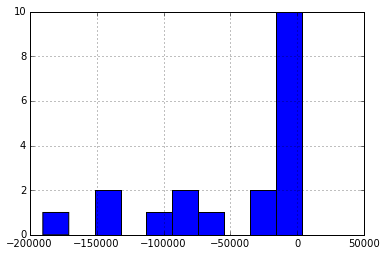

In [54]:
lambda_compensation = pd.Series(survey_scenario.simulation.calculate("lambda_compensation"))
lambda_compensation.loc[(lambda_compensation == -np.inf)|lambda_compensation.isnull()]=0
lambda_compensation.loc[(lambda_compensation == np.inf)|lambda_compensation.isnull()]=0
lambda_compensation[np.abs(lambda_compensation)-2000 >= 0 ].hist(bins = 10)
#plt.xlim(-20,20)

#### Pourcentage du sample à 0

In [55]:
lambda_compensation = pd.Series(survey_scenario.simulation.calculate("lambda_compensation"))
#lambda_compensation.loc[(lambda_compensation == -np.inf)|lambda_compensation.isnull()]=0
#lambda_compensation.loc[(lambda_compensation == np.inf)|lambda_compensation.isnull()]=0
prct1 = lambda_compensation[np.abs(lambda_compensation)==0].shape[0]/lambda_compensation.shape[0]
print "{} % du sample à un lambda égal à 0 ".format(round(prct1,2)*100)

50.0 % du sample à un lambda égal à 0 


#### Pourcentage du sample presque à 0

In [56]:
lambda_compensation = pd.Series(survey_scenario.simulation.calculate("lambda_compensation"))
lambda_compensation.loc[(lambda_compensation == -np.inf)|lambda_compensation.isnull()]=0
lambda_compensation.loc[(lambda_compensation == np.inf)|lambda_compensation.isnull()]=0
prct1 = lambda_compensation[np.abs(lambda_compensation)<0.01].shape[0]/lambda_compensation.shape[0]
print "{} % du sample à un lambda égal à 0 ".format(round(prct1,2)*100)

90.0 % du sample à un lambda égal à 0 


#### Pourcentage du sample > ou < à  0

In [57]:
lambda_compensation = pd.Series(survey_scenario.simulation.calculate("lambda_compensation"))
lambda_compensation.loc[(lambda_compensation == -np.inf)|lambda_compensation.isnull()]=0
lambda_compensation.loc[(lambda_compensation == np.inf)|lambda_compensation.isnull()]=0
prct1 = lambda_compensation[lambda_compensation<0].shape[0]/lambda_compensation.shape[0]
prct2 = lambda_compensation[lambda_compensation>0].shape[0]/lambda_compensation.shape[0]
print "{} % du sample à un lambda < à 0 ".format(round(prct1,2)*100)
print "{} % du sample à un lambda > à 0 ".format(round(prct2,2)*100)

23.0 % du sample à un lambda < à 0 
28.0 % du sample à un lambda > à 0 


In [58]:
lambda_compensation = pd.Series(survey_scenario.simulation.calculate("lambda_compensation"))
lambda_compensation.loc[(lambda_compensation == -np.inf)|lambda_compensation.isnull()]=0
lambda_compensation.loc[(lambda_compensation == np.inf)|lambda_compensation.isnull()]=0
prct1 = lambda_compensation[lambda_compensation<-0.01].shape[0]/lambda_compensation.shape[0]
prct2 = lambda_compensation[lambda_compensation>0.01].shape[0]/lambda_compensation.shape[0]
print "{} % du sample à un lambda < à -0.01 ".format(round(prct1,2)*100)
print "{} % du sample à un lambda > à 0.01 ".format(round(prct2,2)*100)

2.0 % du sample à un lambda < à -0.01 
7.0 % du sample à un lambda > à 0.01 


In [59]:
lambda_compensation = pd.Series(survey_scenario.simulation.calculate("lambda_compensation"))
lambda_compensation.loc[(lambda_compensation == -np.inf)|lambda_compensation.isnull()]=0
lambda_compensation.loc[(lambda_compensation == np.inf)|lambda_compensation.isnull()]=0
prct1 = lambda_compensation[lambda_compensation<-0.01].shape[0]/lambda_compensation[np.abs(lambda_compensation)>0.01].shape[0]
prct2 = lambda_compensation[lambda_compensation>0.01].shape[0]/lambda_compensation[np.abs(lambda_compensation)>0.01].shape[0]
print "{} % du sample à un lambda < à -0.01 ".format(round(prct1,2)*100)
print "{} % du sample à un lambda > à 0.01 ".format(round(prct2,2)*100)

25.0 % du sample à un lambda < à -0.01 
75.0 % du sample à un lambda > à 0.01 


#### Pourcentage du sample entre -20 et 20

In [60]:
lambda_compensation = pd.Series(survey_scenario.simulation.calculate("lambda_compensation"))
lambda_compensation.loc[(lambda_compensation == -np.inf)|lambda_compensation.isnull()]=0
lambda_compensation.loc[(lambda_compensation == np.inf)|lambda_compensation.isnull()]=0
prct1 = lambda_compensation[np.abs(lambda_compensation)>70].shape[0]/lambda_compensation.shape[0]
print "{} % du sample à un lambda supérieur  à 70 ".format(round(prct1,2)*100)

1.0 % du sample à un lambda supérieur  à 70 


#### Lambda compensation négatif du à la décote ?

In [61]:
pd.Series(survey_scenario.simulation.calculate_add("decote_mensuel_times_12")/12).mean()

179.2312

In [62]:
decote_monthly = pd.Series(survey_scenario.simulation.calculate_add("decote_mensuel_times_12")/12)
decote_annual =  pd.Series(survey_scenario.simulation.calculate_add("decote"))

In [63]:
filtre_unequal_decote = decote_monthly != decote_annual

In [64]:
lambda_compensation[filtre_unequal_decote].shape

(23034,)

(-20, 20)

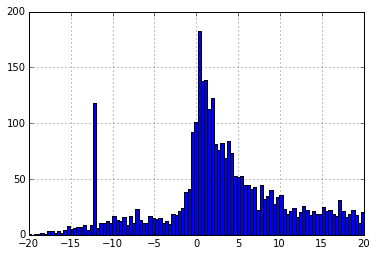

In [65]:
lambda_compensation[filtre_unequal_decote&
                    (np.abs(lambda_compensation)>.1)&
                    (np.abs(lambda_compensation)<100)].hist(bins = 500)
plt.xlim(-20,20)

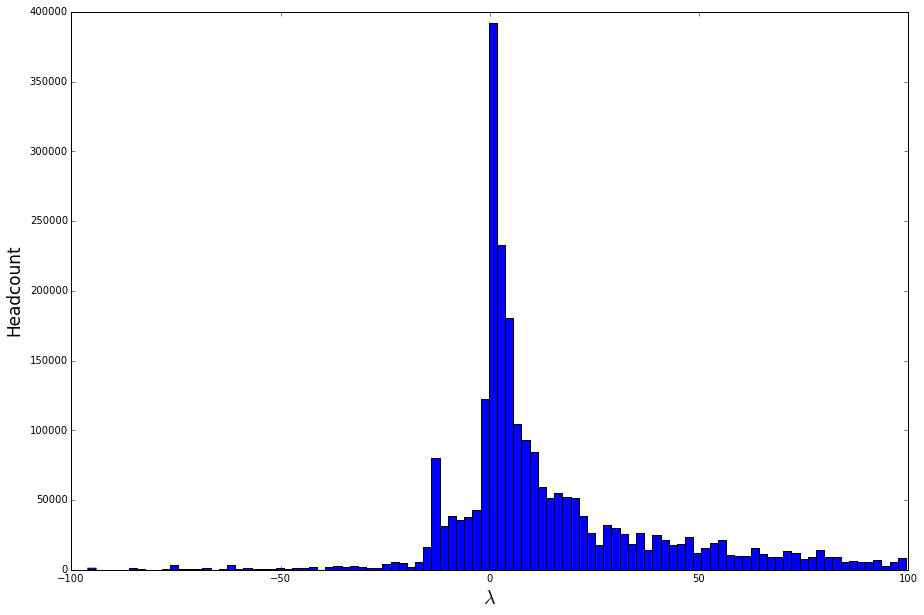

In [66]:
graph_filter = filtre_unequal_decote & (np.abs(lambda_compensation)>.1) & (np.abs(lambda_compensation)<100)


to_graph_foyer = lambda_compensation[graph_filter]
poids = pd.Series(weight_foyers)[graph_filter]

plt.figure(figsize=(15,10))
plt.hist(to_graph_foyer.values, bins = 100, weights = poids.values)
plt.xlabel(r'$\lambda$',fontsize = 20 )
plt.ylabel('Headcount',fontsize = 17)

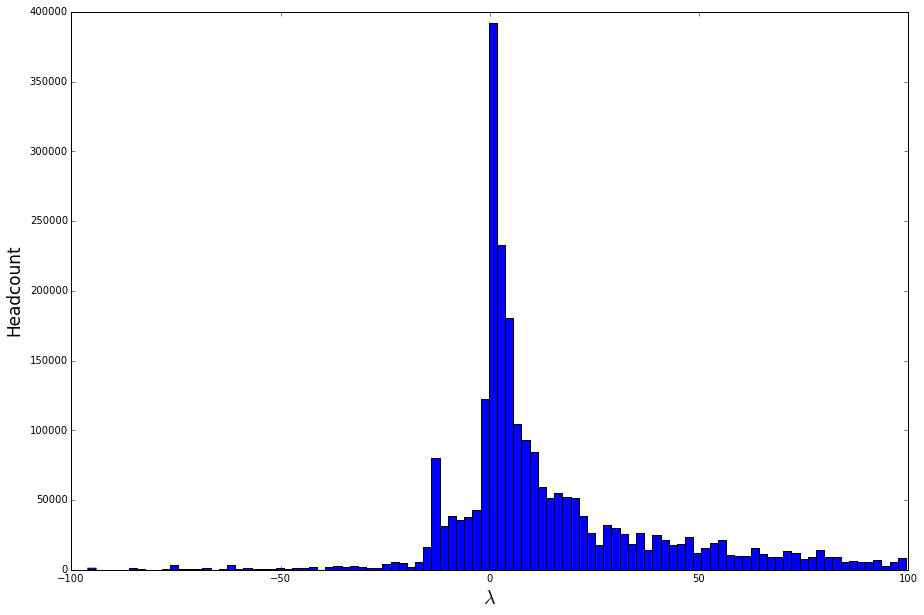

In [67]:
graph_filter = filtre_unequal_decote & (np.abs(lambda_compensation)>.1)&(np.abs(lambda_compensation)<100)


to_graph_foyer = lambda_compensation[filtre_unequal_decote&
                    (np.abs(lambda_compensation)>.1)&
                    (np.abs(lambda_compensation)<100)]
poids = pd.Series(weight_foyers)[
        filtre_unequal_decote&
        (np.abs(lambda_compensation)>.1)&
        (np.abs(lambda_compensation)<100)]

plt.figure(figsize=(15,10))
plt.hist(to_graph_foyer.values, bins = 100, weights = poids.values)
plt.xlabel(r'$\lambda$',fontsize = 20 )
plt.ylabel('Headcount',fontsize = 17)

NameError: name 'nb_minor_ticks' is not defined

/usr/local/lib/python2.7/site-packages/matplotlib/figure.py:1653: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


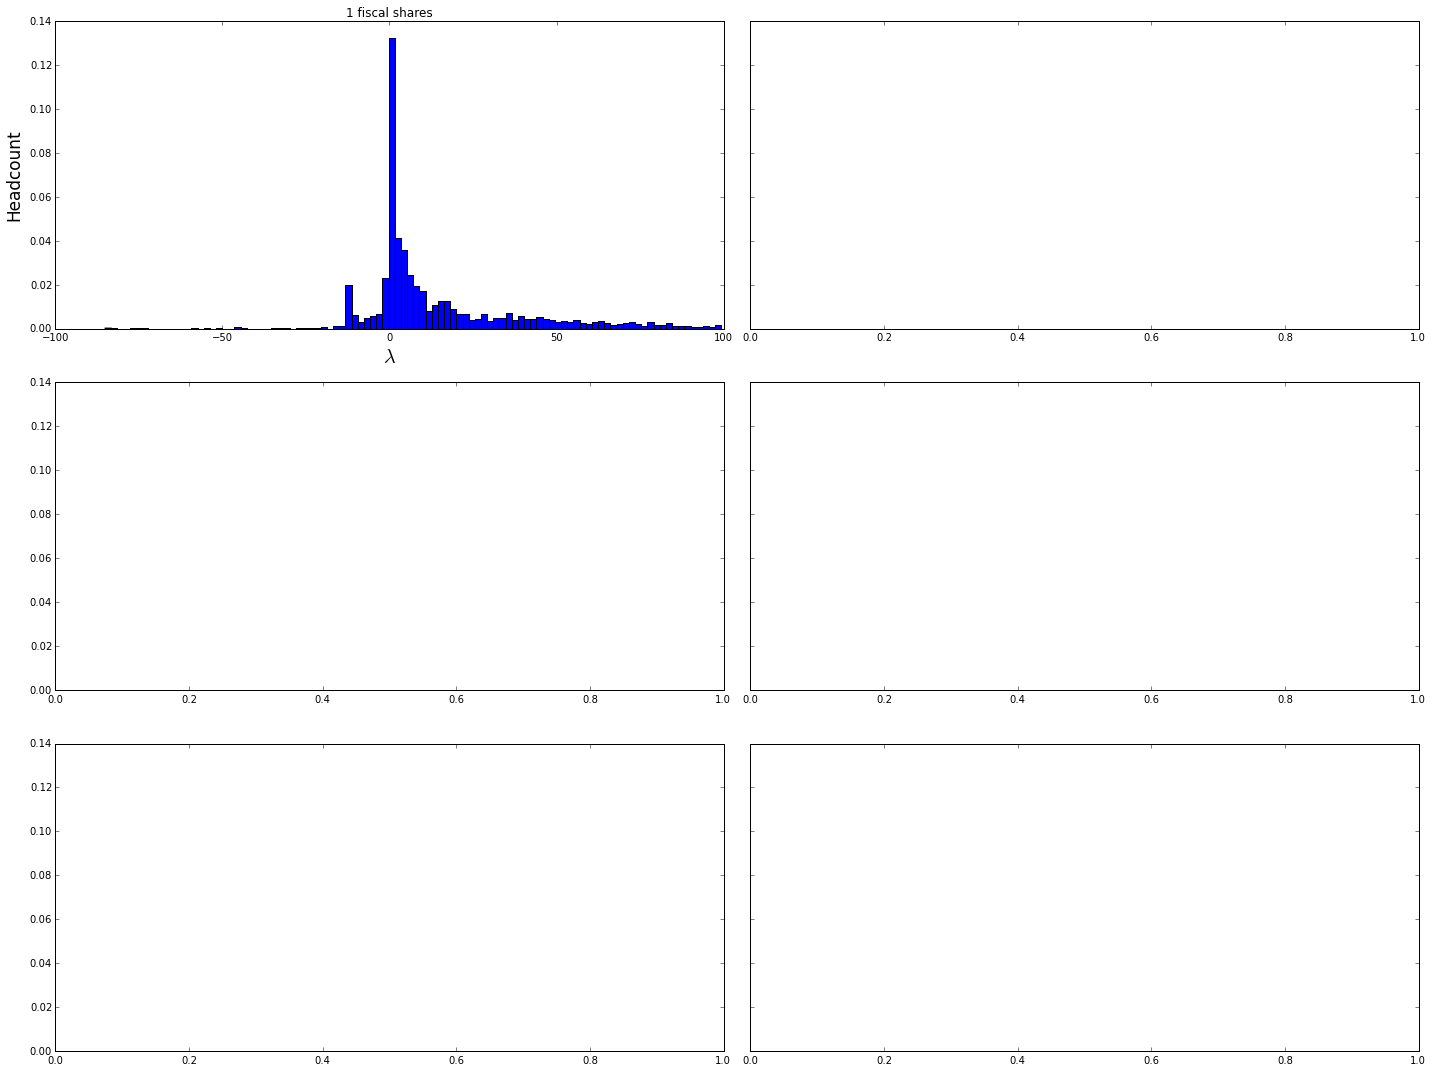

In [68]:
from matplotlib.ticker import AutoMinorLocator
nb_parts_list = [1,1.5,2,2.5,3,4]
graph_filter = (np.abs(lambda_compensation)>.1)&(np.abs(lambda_compensation)<100)

nb_subplots_lines = len(nb_parts_list)//2 + len(nb_parts_list)%2 

fig, ax = plt.subplots(nb_subplots_lines,2,sharey = True, figsize = (20, 15), tight_layout = True)
count = 0
for parts in nb_parts_list:
    graph_filter = (np.abs(lambda_compensation)>.001)&(np.abs(lambda_compensation)<100) & (simulation.calculate('nbptr') == parts)
    i = count//2
    j = count %2
    
    ax[i,j].hist(lambda_compensation[graph_filter].values, bins = 100, normed = True)#, weights = poids.values)
    ax[i,j].set_xlabel(r'$\lambda$',fontsize = 20 )
    ax[i,j].set_ylabel('Headcount',fontsize = 17)
    ax[i,j].set_title('{} fiscal shares'.format(parts))
    ax[i,j].xaxis.set_minor_locator(AutoMinorLocator(nb_minor_ticks))
    ax[i,j].yaxis.set_minor_locator(AutoMinorLocator(nb_minor_ticks))
    ax[i,j].grid(which = 'both')
    count +=1
plt.savefig("image_result_of_mensualisation/lambda_compensation_by_fiscal_shares.png")

In [69]:
lambda_compensation_menage = pd.Series(switch_entity('lambda_compensation', 'menage'))
graph_filter_menage =  (np.abs(lambda_compensation_menage)>.1)&(np.abs(lambda_compensation_menage)<100)

ValueError: weights should have the same shape as x

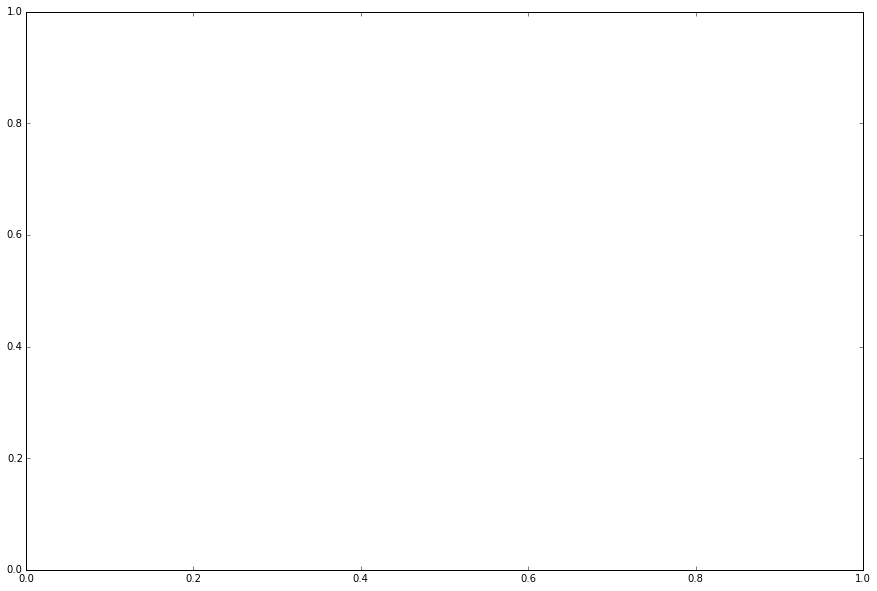

In [70]:
to_graph_foyer = lambda_compensation[graph_filter]
poids_menage = pd.Series(weight_menages)[graph_filter_menage]

plt.figure(figsize=(15,10))
plt.hist(to_graph_foyer.values, bins = 100, weights = poids.values)
plt.xlabel(r'$\lambda$',fontsize = 20 )
plt.ylabel('Headcount',fontsize = 17)

ValueError: weights should have the same shape as x

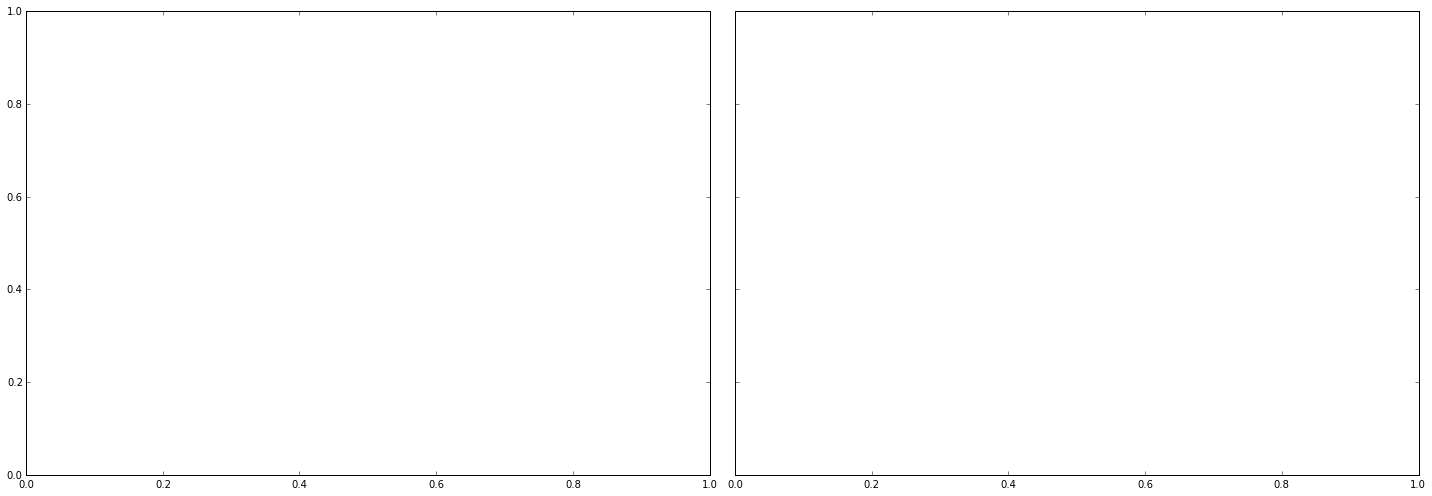

In [71]:

nb_minor_ticks = 5
fig, ax = plt.subplots(1,2,sharey = True, figsize = (20, 7), tight_layout = True)

to_graph_menage = lambda_compensation_menage[graph_filter_menage]
poids_menage = pd.Series(weight_menages)[graph_filter_menage]


ax[0].hist(to_graph_foyer.values, bins = 100, weights = poids.values)
ax[0].set_xlabel(r'$\lambda$',fontsize = 20 )
ax[0].set_ylabel('Headcount',fontsize = 17)
ax[0].set_title('Fiscal Household')
ax[0].xaxis.set_minor_locator(AutoMinorLocator(nb_minor_ticks))
ax[0].yaxis.set_minor_locator(AutoMinorLocator(nb_minor_ticks))
ax[0].grid(which = 'both')



ax[1].hist(to_graph_menage.values, bins = 100, weights = poids_menage.values)
ax[1].set_xlabel(r'$\lambda$',fontsize = 20)
#ax[1].set_ylabel('Headcount',fontsize = 17)
ax[1].set_title('Household')
ax[1].xaxis.set_minor_locator(AutoMinorLocator(nb_minor_ticks))
ax[1].yaxis.set_minor_locator(AutoMinorLocator(nb_minor_ticks))
ax[1].grid(which = 'both')

ValueError: weights should have the same shape as x

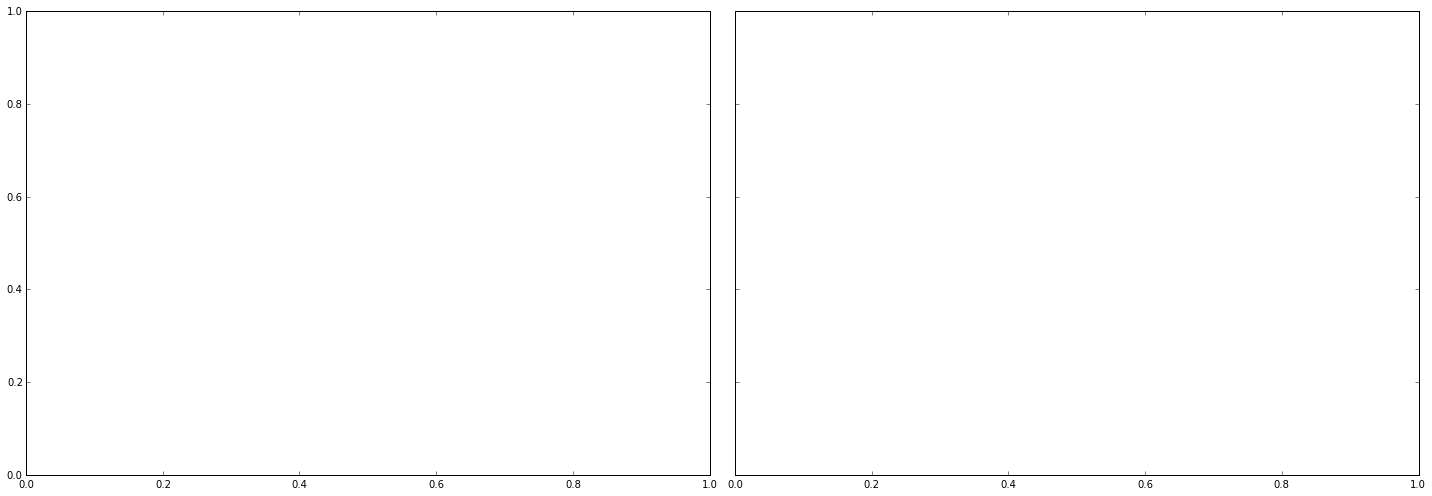

In [72]:
from matplotlib.ticker import AutoMinorLocator
nb_minor_ticks = 5
fig, ax = plt.subplots(1,2,sharey = True, figsize = (20, 7), tight_layout = True)

to_graph_menage = lambda_compensation_menage[graph_filter_menage]
poids_menage = pd.Series(weight_menages)[graph_filter_menage]
ax_nb = 0
ax[ax_nb].hist(to_graph_foyer.values, bins = 100,normed = True, weights = poids.values)
ax[ax_nb].set_xlabel(r'$\lambda$',fontsize = 20 )
ax[ax_nb].set_ylabel('Headcount',fontsize = 17)
ax[ax_nb].set_title('Fiscal Household')
ax[ax_nb].xaxis.set_minor_locator(AutoMinorLocator(nb_minor_ticks))
ax[ax_nb].yaxis.set_minor_locator(AutoMinorLocator(nb_minor_ticks))
ax[ax_nb].grid(which = 'both')


ax_nb = 1
ax[ax_nb].hist(to_graph_menage.values, bins = 100, normed = True ,weights = poids_menage.values)
ax[ax_nb].set_xlabel(r'$\lambda$',fontsize = 20)
#ax[1].set_ylabel('Headcount',fontsize = 17)
ax[ax_nb].set_title('Household')
ax[ax_nb].xaxis.set_minor_locator(AutoMinorLocator(nb_minor_ticks))
ax[ax_nb].yaxis.set_minor_locator(AutoMinorLocator(nb_minor_ticks))
ax[ax_nb].grid(which = 'both')

In [73]:
to_graph_menage = lambda_compensation[filtre_unequal_decote&
                    (np.abs(lambda_compensation)>.1)&
                    (np.abs(lambda_compensation)<100)]

In [74]:
lambda_zero = pd.Series(lambda_compensation == 0 )
pd.Series(weight_foyers)[lambda_zero].sum()



16291830.0

In [75]:
index_exceptional_lambda = lambda_compensation[np.abs(lambda_compensation)>100].index

In [76]:
df = survey_scenario.create_data_frame_by_entity_key_plural(['decote_gain_fiscal','decote_gain_fiscal_mensuel_times_12',"irpp",'irpp_mensuel', 'lambda_compensation'])['foyers_fiscaux']
df['decote_gain_fiscal_mensuel'] = df.decote_gain_fiscal_mensuel_times_12/12
df.iloc[index_exceptional_lambda]

,decote_gain_fiscal,decote_gain_fiscal_mensuel_times_12,irpp,irpp_mensuel,lambda_compensation,decote_gain_fiscal_mensuel
4,252.503723,146.684967,-108.488831,-1942.908325,202.905991,12.223747
128,218.857468,0.000000,-209.427597,-3179.729248,170.195419,0.000000
234,238.712494,0.000000,-149.862518,-1831.854126,134.682770,0.000000
405,269.017517,2914.672363,0.400000,-25.741962,-784.258911,242.889359
468,-0.000000,0.000000,-425.854980,-5981.230957,156.542755,0.000000
588,133.102509,0.000000,-466.692474,-4444.631348,102.284203,0.000000
590,248.447495,0.000000,-120.657516,-5307.629395,515.870605,0.000000
1892,231.562500,0.000000,-171.312500,-5638.628906,382.971466,0.000000
2104,232.910004,0.000000,-167.269989,-3604.862549,246.613953,0.000000
2246,254.062500,0.000000,-103.812500,-4504.193848,508.653381,0.000000


In [77]:
survey_scenario.simulation.calculate("irpp_mensuel","2009-08")[4]

-971.45416

In [78]:
df["difference"] = np.abs(df.decote_gain_fiscal- df.decote_gain_fiscal_mensuel)>0.01
df[lambda_compensation == -12].difference.value_counts()

True     102
False      5
dtype: int64

In [79]:
df.shape

(59874, 7)

In [80]:
df[lambda_compensation == -12][['decote_gain_fiscal', 'decote_gain_fiscal_mensuel', 'lambda_compensation',"irpp",'irpp_mensuel' ]]

,decote_gain_fiscal,decote_gain_fiscal_mensuel,lambda_compensation,irpp,irpp_mensuel
743,157.952423,239.030014,-12,-392.142731,-0
1391,257.068756,273.102509,-12,-94.793732,-0
1666,175.872437,262.359161,-12,-338.382690,-0
2221,262.664978,244.310043,-12,-78.005035,-0
2560,211.432495,207.514969,-12,-231.702515,-0
3334,197.922501,82.885002,-12,-272.232483,-0
3482,231.988785,257.262482,-12,-170.033646,-0
3983,137.402496,0.000000,-12,-453.792511,-0
4108,254.827515,0.000000,-12,-101.517456,-0
4374,252.522507,0.000000,-12,-108.432480,-0


In [81]:
df = survey_scenario.create_data_frame_by_entity_key_plural(['decote_gain_fiscal','decote_gain_fiscal_mensuel_times_12',"irpp",'irpp_mensuel', 'lambda_compensation'])['foyers_fiscaux']
df.decote_gain_fiscal_mensuel_times_12 = df.decote_gain_fiscal_mensuel_times_12/12
df.lambda_compensation[df.lambda_compensation>70] = 0 #autrement les histogrames prennent trois heures à grapher pour quelques observations
df.lambda_compensation[df.lambda_compensation< -70] = 0

In [82]:
df[np.abs(df.decote_gain_fiscal-df.decote_gain_fiscal_mensuel_times_12)+1>0].shape

(59874, 5)

(-20, 20)

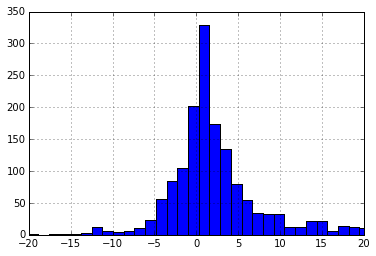

In [83]:
df.lambda_compensation[(np.abs(df.decote_gain_fiscal-df.decote_gain_fiscal_mensuel_times_12)-1<0)
                      & (np.abs(df.lambda_compensation)>0.1)].hist(bins = 100)
plt.xlim(-20,20)

In [84]:
df.lambda_compensation[(np.abs(df.decote_gain_fiscal-df.decote_gain_fiscal_mensuel_times_12)-0.1>0)
                      & (np.abs(df.lambda_compensation)>0.1)].mean()

7.6328607

In [85]:
df[(np.abs(df.decote_gain_fiscal-df.decote_gain_fiscal_mensuel_times_12)-0.1>0)
                      & (np.abs(df.lambda_compensation)>0.1)]

,decote_gain_fiscal,decote_gain_fiscal_mensuel_times_12,irpp,irpp_mensuel,lambda_compensation
7,-0.000000,223.836288,-2966.810059,-7234.854004,17.263165
10,0.000000,39.012215,153.500000,-41.694618,-15.259514
38,76.113708,42.886242,-576.658875,-897.256348,6.671482
57,121.699951,185.417496,-347.900146,-156.747498,-6.593362
67,-0.000000,136.980972,-950.567383,-1734.394775,9.895069
74,133.872498,0.000000,-464.382507,-1367.037476,23.325294
85,16.202515,0.000000,-817.392456,-5112.797852,63.060120
101,220.742493,0.000000,-203.772522,-754.381226,32.424900
157,49.032501,59.248749,-718.902466,-741.326172,0.374299
159,83.599976,0.000000,69.500000,-210.421295,-48.331738


In [86]:
df[df.lambda_compensation<-1]

,decote_gain_fiscal,decote_gain_fiscal_mensuel_times_12,irpp,irpp_mensuel,lambda_compensation
10,0.000000,39.012215,153.500000,-41.694618,-15.259514
57,121.699951,185.417496,-347.900146,-156.747498,-6.593362
159,83.599976,0.000000,69.500000,-210.421295,-48.331738
219,39.092499,209.385391,-748.722534,-93.510429,-10.501281
273,44.823730,218.486313,-578.528809,-57.541183,-10.806465
372,-0.000000,-0.000000,-1407.664917,-1190.384888,-1.852259
450,-0.000000,0.000000,-1409.734985,272.399994,-14.318733
554,-0.000000,-0.000000,-1104.777588,-1007.197327,-1.059908
722,152.197510,232.167496,-73.407471,166.502502,-39.218346
743,157.952423,239.030014,-392.142731,-0.000000,-12.000000


In [87]:
df[df.lambda_compensation<-1][df.decote_gain_fiscal> df.decote_gain_fiscal_mensuel_times_12]

/usr/local/lib/python2.7/site-packages/pandas/core/frame.py:1825: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  "DataFrame index.", UserWarning)


,decote_gain_fiscal,decote_gain_fiscal_mensuel_times_12,irpp,irpp_mensuel,lambda_compensation
159,83.599976,0.000000,69.500000,-210.421295,-48.331738
1886,118.345001,0.000000,171.535004,-707.201294,-61.473377
2200,163.817490,0.000000,1253.000000,-258.154144,-14.472346
2221,262.664978,244.310043,-78.005035,-0.000000,-12.000000
2245,182.545105,27.949804,110.000000,-166.983917,-30.216427
2433,147.207520,131.401535,147.000000,131.180328,-1.291402
2560,211.432495,207.514969,-231.702515,-0.000000,-12.000000
3170,6.792513,0.000000,191.800003,-564.493103,-47.317608
3334,197.922501,82.885002,-272.232483,-0.000000,-12.000000
3444,260.589996,0.000000,909.200012,302.976807,-8.001186


## Compensated irpp

In [88]:
print max(pd.Series(survey_scenario.simulation.calculate_add('compensated_irpp_mensuel') -  survey_scenario.simulation.calculate_add('irpp')))
print min(pd.Series(survey_scenario.simulation.calculate_add('compensated_irpp_mensuel') -  survey_scenario.simulation.calculate_add('irpp')))

0.09375
-0.03125


In [89]:
df = survey_scenario.create_data_frame_by_entity_key_plural(['decote_gain_fiscal','decote_gain_fiscal_mensuel_times_12',"irpp",'irpp_mensuel', 'lambda_compensation', 'compensated_irpp_mensuel'])['foyers_fiscaux']
df.decote_gain_fiscal_mensuel_times_12 = df.decote_gain_fiscal_mensuel_times_12/12
#df.lambda_compensation[df.lambda_compensation>70] = 0 #autrement les histogrames prennent trois heures à grapher pour quelques observations
#df.lambda_compensation[df.lambda_compensation< -70] = 0
#df.compensated_irpp_mensuel = df.compensated_irpp_mensuel
df

,compensated_irpp_mensuel,decote_gain_fiscal,decote_gain_fiscal_mensuel_times_12,irpp,irpp_mensuel,lambda_compensation
0,0.000000,5.894867,10.871246,0.000000,-7.903255,0.000000e+00
1,0.000000,0.000000,0.000000,0.000000,-0.000000,0.000000e+00
2,0.000000,0.000000,0.000000,0.000000,-0.000000,0.000000e+00
3,-1378.829712,-0.000000,-0.000000,-1378.829712,-1378.829956,1.907349e-06
4,-108.488831,252.503723,12.223747,-108.488831,-1942.908325,2.029060e+02
5,-792.612549,24.462494,24.462494,-792.612549,-792.612366,-2.861023e-06
6,-9160.150391,-0.000000,-0.000000,-9160.150391,-9160.149414,-9.536743e-07
7,-2966.809814,-0.000000,223.836288,-2966.810059,-7234.854004,1.726316e+01
8,0.000000,230.505005,230.504959,0.000000,-0.000000,0.000000e+00
9,0.000000,102.025002,102.025017,0.000000,-0.000000,0.000000e+00


In [90]:
df = survey_scenario.create_data_frame_by_entity_key_plural(['decote_gain_fiscal','decote_gain_fiscal_mensuel_times_12',"irpp",'irpp_mensuel', 'lambda_compensation', 'compensated_irpp_mensuel'])['foyers_fiscaux']
df.decote_gain_fiscal_mensuel_times_12 = df.decote_gain_fiscal_mensuel_times_12/12
#df.lambda_compensation[df.lambda_compensation>70] = 0 #autrement les histogrames prennent trois heures à grapher pour quelques observations
#df.lambda_compensation[df.lambda_compensation< -70] = 0
#df.compensated_irpp_mensuel = df.compensated_irpp_mensuel
df

,compensated_irpp_mensuel,decote_gain_fiscal,decote_gain_fiscal_mensuel_times_12,irpp,irpp_mensuel,lambda_compensation
0,0.000000,5.894867,10.871246,0.000000,-7.903255,0.000000e+00
1,0.000000,0.000000,0.000000,0.000000,-0.000000,0.000000e+00
2,0.000000,0.000000,0.000000,0.000000,-0.000000,0.000000e+00
3,-1378.829712,-0.000000,-0.000000,-1378.829712,-1378.829956,1.907349e-06
4,-108.488831,252.503723,12.223747,-108.488831,-1942.908325,2.029060e+02
5,-792.612549,24.462494,24.462494,-792.612549,-792.612366,-2.861023e-06
6,-9160.150391,-0.000000,-0.000000,-9160.150391,-9160.149414,-9.536743e-07
7,-2966.809814,-0.000000,223.836288,-2966.810059,-7234.854004,1.726316e+01
8,0.000000,230.505005,230.504959,0.000000,-0.000000,0.000000e+00
9,0.000000,102.025002,102.025017,0.000000,-0.000000,0.000000e+00


In [91]:
df[df.compensated_irpp_mensuel - df.irpp<2][['irpp', 'compensated_irpp_mensuel', 'irpp_mensuel']]

,irpp,compensated_irpp_mensuel,irpp_mensuel
0,0.000000,0.000000,-7.903255
1,0.000000,0.000000,-0.000000
2,0.000000,0.000000,-0.000000
3,-1378.829712,-1378.829712,-1378.829956
4,-108.488831,-108.488831,-1942.908325
5,-792.612549,-792.612549,-792.612366
6,-9160.150391,-9160.150391,-9160.149414
7,-2966.810059,-2966.809814,-7234.854004
8,0.000000,0.000000,-0.000000
9,0.000000,0.000000,-0.000000


In [92]:
print survey_scenario.compute_aggregate('compensated_irpp_mensuel')
print survey_scenario.compute_aggregate('irpp')

-48038862125.8
-48038862065.7


In [93]:
impot_mensuel_times_12 = survey_scenario.simulation.calculate("irpp_mensuel", period)*12
lambda_compensation = survey_scenario.simulation.calculate("lambda_compensation", period.this_year)



compensated_irpp = impot_mensuel_times_12/(12 + lambda_compensation)

In [94]:
compensated_irpp[743]

nan

In [95]:
(survey_scenario.simulation.calculate("irpp", period.this_year) == 0)*0

array([0, 0, 0, ..., 0, 0, 0])

In [96]:
compensated_irpp = (survey_scenario.simulation.calculate("irpp", period.this_year) == 0) * 0 + \
                ~(survey_scenario.simulation.calculate("irpp", period.this_year) == 0) * np.nan_to_num(compensated_irpp) ;compensated_irpp[[4,743]]

array([-108.48883057,    0.        ])

In [97]:
compensated_irpp = (
                (survey_scenario.simulation.calculate_add("irpp_mensuel", period) == 0) * #Condition
                (survey_scenario.simulation.calculate("irpp", period.this_year)/12) # on répartit sur l'année
            ) + ~(survey_scenario.simulation.calculate_add("irpp_mensuel", period) == 0) * compensated_irpp #condition opposée
compensated_irpp[[4,743]]

array([-108.48883057,  -32.67856216])

In [98]:
df[df.lambda_compensation.isnull()]

,compensated_irpp_mensuel,decote_gain_fiscal,decote_gain_fiscal_mensuel_times_12,irpp,irpp_mensuel,lambda_compensation


In [99]:
survey_scenario.simulation.calculate_add('irpp')

array([ 0.,  0.,  0., ...,  0.,  0.,  0.], dtype=float32)

In [100]:
survey_scenario.compute_aggregate('compensated_irpp_mensuel')

-48038862125.764519

In [101]:
lambda_compensation = survey_scenario.simulation.calculate('lambda_compensation')
np.all(lambda_compensation != np.nan)
lambda_compensation != np.nan
hello = lambda_compensation[1]
assert np.all(np.isfinite(lambda_compensation))


In [102]:
sal_pen_df = survey_scenario.create_data_frame_by_entity_key_plural_with_monthly_basis_selector(['irpp'], ['irpp_mensuel','compensated_irpp_mensuel'])['foyers_fiscaux']

sal_pen_df.T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,...,59774,59775,59776,59777,59778,59779,59780,59781,59782,59783,59784,59785,59786,59787,59788,59789,59790,59791,59792,59793,59794,59795,59796,59797,59798,59799,59800,59801,59802,59803,59804,59805,59806,59807,59808,59809,59810,59811,59812,59813,59814,59815,59816,59817,59818,59819,59820,59821,59822,59823,59824,59825,59826,59827,59828,59829,59830,59831,59832,59833,59834,59835,59836,59837,59838,59839,59840,59841,59842,59843,59844,59845,59846,59847,59848,59849,59850,59851,59852,59853,59854,59855,59856,59857,59858,59859,59860,59861,59862,59863,59864,59865,59866,59867,59868,59869,59870,59871,59872,59873
irpp,0.000000,0,0,-1378.829712,-108.488831,-792.612549,-9160.150391,-2966.810059,0,0,153.500000,-2335.952637,0,-1309.255005,0,-2104.827637,0.000000,166.152588,-4151.707031,-3237.300049,-2124.675049,-877.314941,-601.944092,737.799988,0.000000,-1072.575317,-1089.632202,-433.722321,0,0.00000,0,-1132.755005,-1087.487549,0,0.000000,778.040283,-79.077332,-5260.950195,-576.658875,-1171.852295,-157.122513,-1710.030518,-8168.149902,-502.418640,-7868.875000,-7178.475098,-7609.375000,0,-700.632874,0,0,0,0,0,0.0000,-557.202698,-219.863785,-347.900146,0.00000,-100.774826,-1554.069702,0,-1177.890015,0,-1053.290039,-176.052505,-25070.472656,-950.567383,0.000000,-7382.575195,-1490.895020,-902.614990,-956.515015,0.000000,-464.382507,-19810.775391,-306.282501,-839.862549,-2150.909424,0.000000,-2422.667725,128.607910,221.765015,-781.379395,0,-817.392456,-1687.875000,-2443.069336,-712.655029,-1361.430542,-504.814941,-450.965210,0.000000,0,-244.102661,-607.182739,0,-1016.015015,-2660.685059,0,...,0.0000,-601.302246,0.000000,-1093.915039,0,-474.908691,-948.814697,-2816.445068,-1445.395020,0,-1058.574951,-2052.189941,-595.650024,-267.612518,-1248.135010,-499.992493,-4005.529785,-1531.915039,0,-319.692688,-202.414978,-321.545105,0.00000,-3714.446777,-2004.694702,-687.770264,0,-748.354553,-1434.970215,-424.152496,-244.002533,-163.542511,0.000000,-202.538803,-597.724976,-9831.699219,-257.890350,0,-1735.875000,-4654.606934,720.587402,0,0,0,0,-414.822540,0,-551.364990,0.000000,-1313.714966,0,-694.752075,0,0,0,-1803.330322,-2510.689941,-122.678955,0,-837.510071,-881.647339,0,-1013.949707,0,-2144.870117,-1179.814941,714.760010,-820.122070,-6603.650879,-476.045013,0,-994.734985,-1435.174683,-699.807495,-322.212524,0,0,-1994.087402,0,0,0,0,0,0,-2146.514893,-15008.900391,-315.072510,0,-7257.776367,-2652.369873,-3179.347412,0.000000,-2050.929932,-198.942520,-1824.654785,-12667.373047,0,0.000000,0,0
compensated_irpp_mensuel_2009-01,0.000000,0,0,-114.902489,0.000000,-66.051056,-763.345947,-4.560170,0,0,-47.092911,-194.662720,0,1.160107,0,-175.402283,0.000000,13.846048,-345.975586,-269.775024,-177.056259,5.842635,-50.162003,61.483326,0.000000,-89.381279,-90.802673,-36.143524,0,0.00000,0,-94.396263,-90.623962,0,0.000000,64.836700,-6.589777,-438.412476,3.267014,-97.654358,-13.093544,-142.502563,-680.679138,-41.868217,-655.739502,-598.206360,-634.114563,0,-58.386074,0,0,0,0,0,0.0000,-46.433563,-18.321983,-28.991678,0.00000,-8.397902,-129.505783,0,0.000000,0,-87.774170,-14.671043,-2089.205811,-12.089419,0.000000,-615.214478,-124.241272,-75.217918,-79.709579,0.000000,0.000000,-1650.897705,-25.523539,-69.988548,-179.242477,0.000000,-201.888992,10.717326,18.480419,-65.114952,0,0.000000,-187.541641,-203.589127,-59.387913,-113.452560,-42.067917,-37.580429,0.000000,0,-20.341888,-50.598564,0,-84.667923,-221.723755,0,...,0.0000,-50.108521,0.000000,-91.159599,0,-39.575726,-79.067886,-234.703735,-160.599442,0,-88.214569,-171.015808,-49.637497,-22.301043,-104.011261,-41.666039,-11.911106,0.000000,0,-26.641056,0.000000,-26.795427,0.00000,-309.537201,-167.057907,-57.314194,0,-62.362877,-119.580856,1.13

In [103]:
survey_scenario.compute_aggregate('compensated_irpp_mensuel')

-48038862125.764519

## Utility annalysis 

In [104]:
survey_scenario.compute_aggregate("utility_ir_annuel") #TODO : find why Nan

-3260.6237666165134

In [105]:
print pd.Series(survey_scenario.simulation.calculate_add('utility_ir_annuel','2009')).mean()
print pd.Series(survey_scenario.simulation.calculate_add('utility_ir_mensuel','2009')).mean()
print pd.Series(survey_scenario.simulation.calculate_add('utility_compensated_ir_mensuel','2009')).mean()
print pd.Series(survey_scenario.simulation.calculate_add('utility_ir_mensuel_rsa_mensuel','2009')).mean()

-0.000124668
-0.000124225
-0.000124254
-0.0044516


In [106]:
u_ir_m_rsa_m = pd.Series(survey_scenario.simulation.calculate_add('utility_ir_mensuel_rsa_mensuel','2009'))
u_c_ir = pd.Series(survey_scenario.simulation.calculate_add('utility_compensated_ir_mensuel','2009'))
u_ir_m = pd.Series(survey_scenario.simulation.calculate_add('utility_ir_mensuel','2009'))
u_ir_a = pd.Series(survey_scenario.simulation.calculate_add('utility_ir_annuel','2009'))


In [107]:
print u_ir_m_rsa_m.mean(),1/u_ir_m_rsa_m.mean()
print u_c_ir.mean(),1/u_c_ir.mean()
print u_ir_m.mean(),1/u_ir_m.mean()
print u_ir_a.mean(),1/u_ir_a.mean()

-0.0044516 -224.638572143
-0.000124254 -8048.01826417
-0.000124225 -8049.90377832
-0.000124668 -8021.32773548


In [108]:
print u_c_ir.describe()
print u_ir_m.describe()
print u_ir_a.describe()

count    49016.000000
mean        -0.000124
std          0.000084
min         -0.000434
25%         -0.000142
50%         -0.000102
75%         -0.000072
max         -0.000002
dtype: float64
count    49016.000000
mean        -0.000124
std          0.000084
min         -0.000434
25%         -0.000142
50%         -0.000102
75%         -0.000072
max         -0.000002
dtype: float64
count    49016.000000
mean        -0.000125
std          0.000084
min         -0.000434
25%         -0.000143
50%         -0.000102
75%         -0.000073
max         -0.000002
dtype: float64


In [109]:
print 1/u_c_ir.describe()
print 1/u_ir_m.describe()
print 1/u_ir_a.describe()

count         0.000020
mean      -8048.018264
std       11957.855674
min       -2304.382731
25%       -7027.008453
50%       -9814.563639
75%      -13805.492695
max     -434795.631517
dtype: float64
count         0.000020
mean      -8049.903778
std       11965.896020
min       -2304.382731
25%       -7027.333256
50%       -9811.970436
75%      -13801.393332
max     -434795.631517
dtype: float64
count         0.000020
mean      -8021.327735
std       11908.191638
min       -2304.382731
25%       -7014.700870
50%       -9791.318337
75%      -13783.512608
max     -434795.631517
dtype: float64


(0, 200)

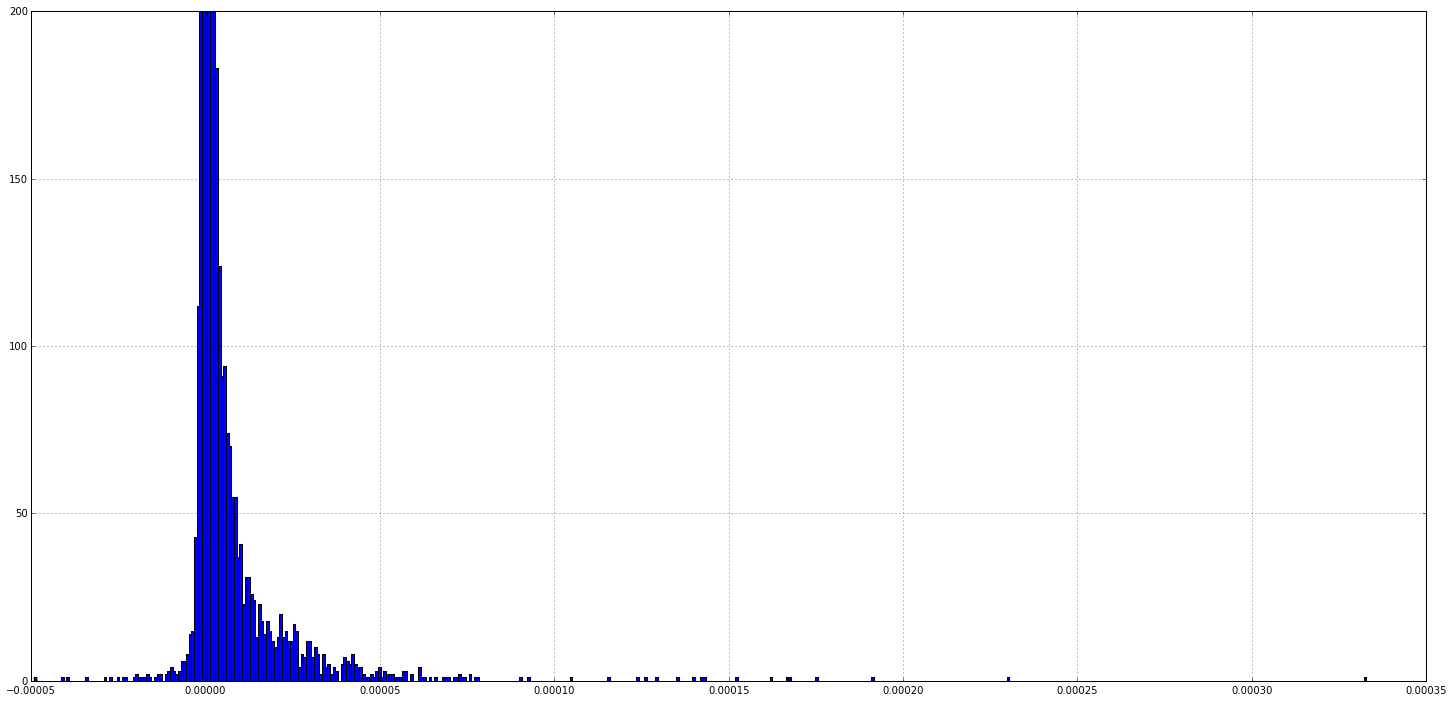

In [110]:
((u_ir_m - u_ir_a)).hist(bins = 500, figsize = (25,12))
plt.ylim(0,200)

In [111]:
((u_ir_m - u_ir_a)<-0.0000001).value_counts()

False    45098
True      3918
dtype: int64

(0, 200)

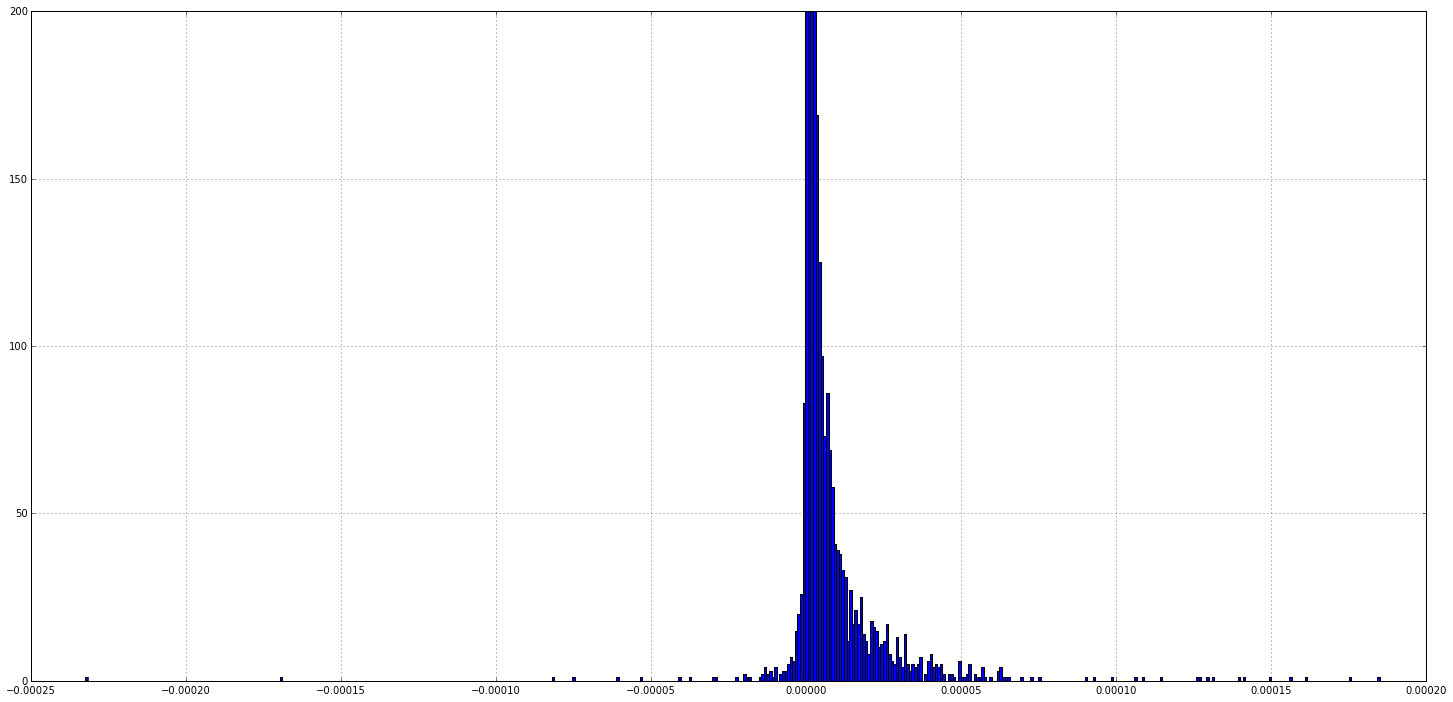

In [112]:
((u_c_ir - u_ir_a)).hist(bins = 500, figsize = (25,12))
plt.ylim(0,200)

In [113]:
((u_c_ir - u_ir_a)<-0.0000001).value_counts()

False    48732
True       284
dtype: int64

##### Graphs with weights

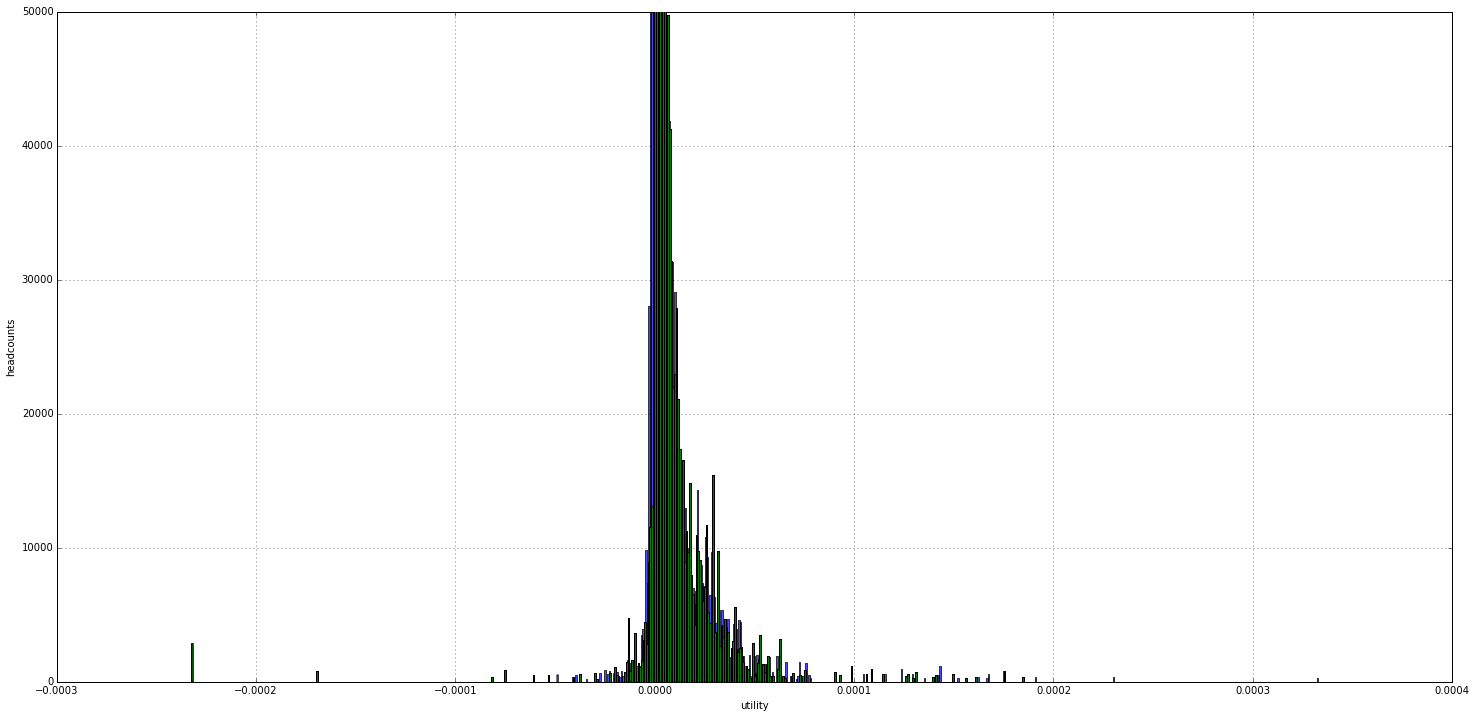

In [114]:
((u_ir_m - u_ir_a)).hist(bins = 500, figsize = (25,12), zorder=1, alpha = 0.7, weights = weight_menages,)
((u_c_ir - u_ir_a)).hist(bins = 500, figsize = (25,12), weights = weight_menages,zorder=10, alpha = 1)
plt.ylim(0,5*10**4)
plt.xlabel('utility')
plt.ylabel('headcounts')

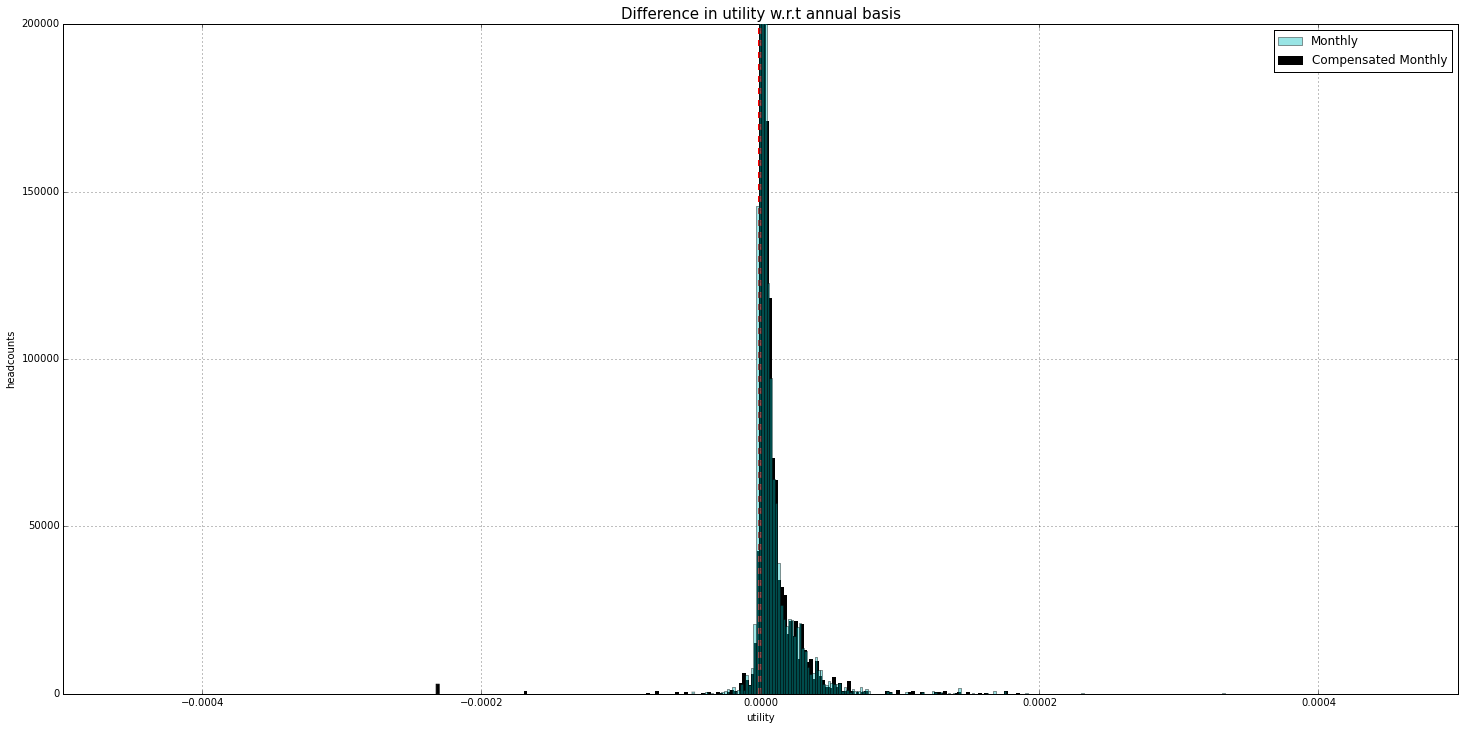

In [115]:
hist1 = ((u_ir_m - u_ir_a)).hist(bins = 200, figsize = (25,12), weights = weight_menages, zorder=10, color = 'c', alpha = 0.4, label = "Monthly")
hist2 = ((u_c_ir - u_ir_a)).hist(bins = 200, figsize = (25,12), weights = weight_menages,zorder=1, color = 'k',alpha = 1, label = "Compensated Monthly")

plt.axvline(x=0, ymax = 10**6, linewidth=4, color = 'r', alpha = 1, linestyle='dashed')
plt.ylim(0,20*10**4)
plt.xlim(-0.0005, 0.0005)
plt.legend()
plt.title("Difference in utility w.r.t annual basis", size = 15)
plt.xlabel('utility')
plt.ylabel('headcounts')

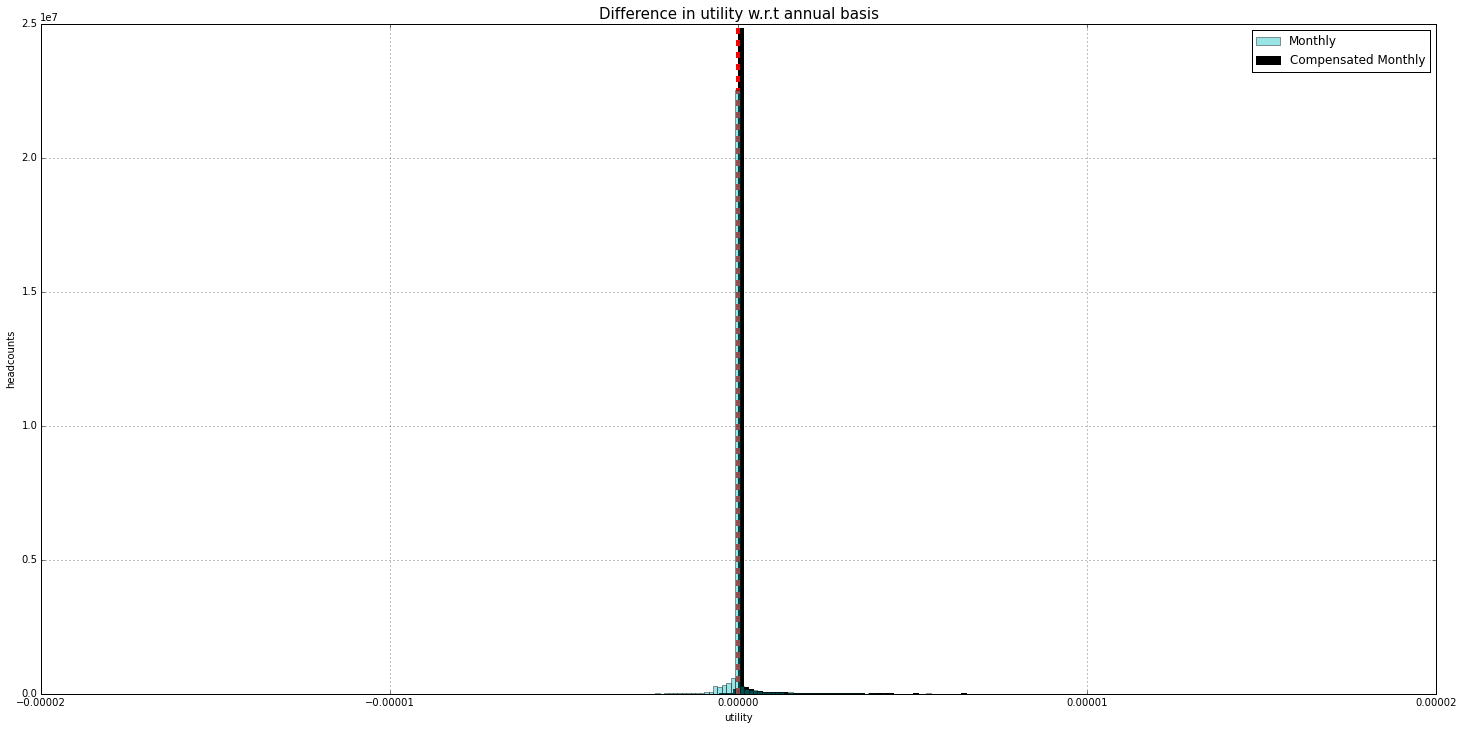

In [116]:
hist1 = ((u_ir_m - u_ir_a)).hist(bins = 3000, figsize = (25,12), weights = weight_menages, zorder=10, color = 'c', alpha = 0.4, label = "Monthly")
hist2 = ((u_c_ir - u_ir_a)).hist(bins = 3000, figsize = (25,12), weights = weight_menages,zorder=1, color = 'k',alpha = 1, label = "Compensated Monthly")

plt.axvline(x=0, ymax = 10**6, linewidth=4, color = 'r', alpha = 1, linestyle='dashed')
#plt.ylim(0,70*10**5)
plt.xlim(-0.00002, 0.00002)
plt.legend()
plt.title("Difference in utility w.r.t annual basis", size = 15)
plt.xlabel('utility')
plt.ylabel('headcounts')

In [117]:
weight_menages = pd.Series(weight_menages)

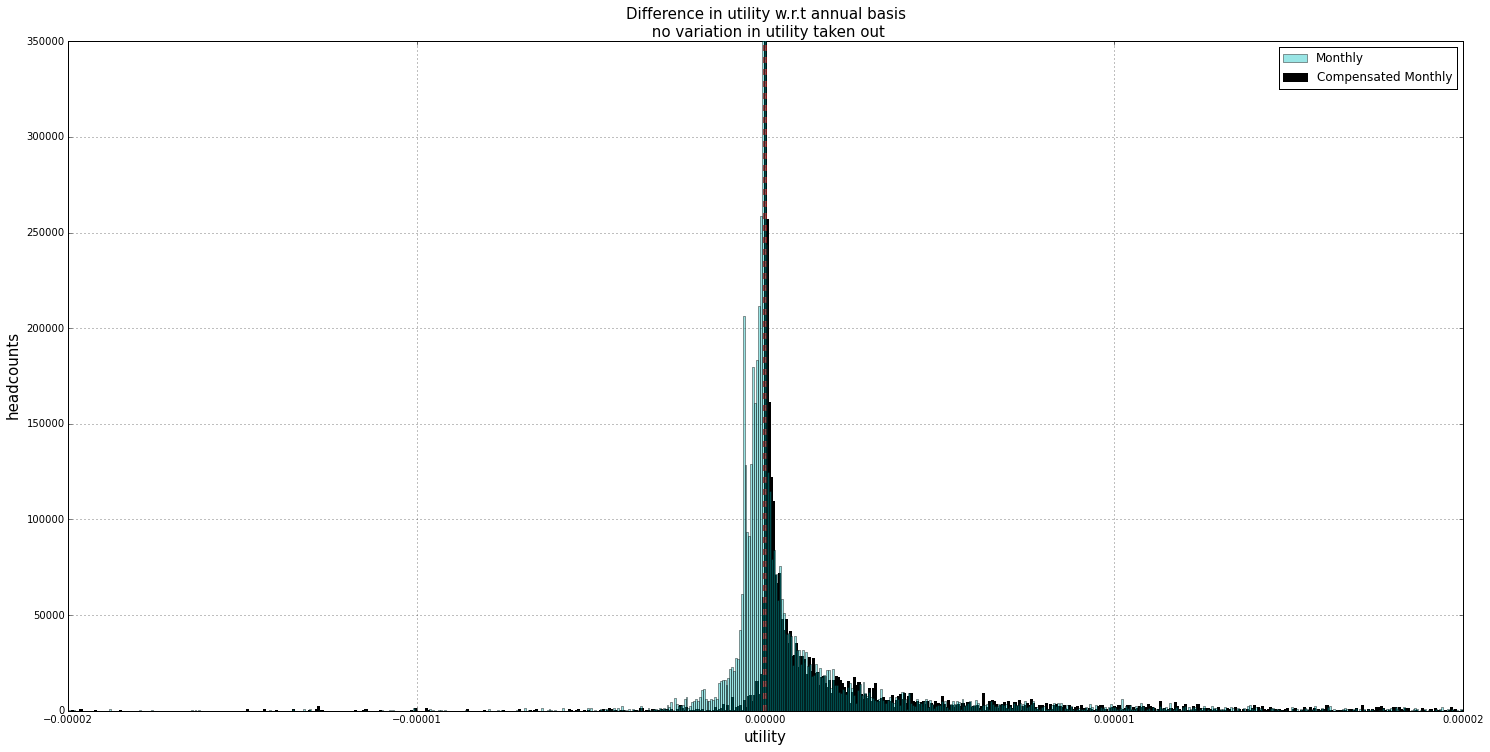

In [118]:
execute_time_consuming_graph = True
if execute_time_consuming_graph == True : 

    hist1 = ((u_ir_m - u_ir_a))[((u_ir_m - u_ir_a))!=0].hist(bins = 7000, figsize = (25,12), weights = pd.Series(weight_menages)[((u_ir_m - u_ir_a))!=0].values, zorder=10, color = 'c', alpha = 0.4, label = "Monthly")
    hist2 = ((u_c_ir - u_ir_a))[((u_c_ir - u_ir_a))!=0].hist(bins = 7000, figsize = (25,12), weights = pd.Series(weight_menages)[((u_c_ir - u_ir_a))!=0].values,zorder=1, color = 'k',alpha = 1, label = "Compensated Monthly")

    plt.axvline(x=0, ymax = 10**6, linewidth=4, color = 'r', alpha = 1, linestyle='dashed')
    plt.ylim(0,35*10**4)
    plt.xlim(-0.00002, 0.00002)
    plt.legend()
    plt.title("Difference in utility w.r.t annual basis \n no variation in utility taken out", size = 15)
    plt.xlabel('utility', size = 15)
    plt.ylabel('headcounts', size = 15)

In [119]:
outliers = pd.Series(np.abs(((u_ir_m - u_ir_a))[((u_ir_m - u_ir_a))!=0])>0.00002).value_counts(normalize = True); outliers

False    0.970197
True     0.029803
dtype: float64

In [120]:
"This graph represent {}% of the tax-unit with varying utility, {}% of that sample are over 0.0002 utility points variation".format(outliers[0], outliers[1])

'This graph represent 0.970196684703% of the tax-unit with varying utility, 0.0298033152967% of that sample are over 0.0002 utility points variation'

In [121]:
pd.Series(weight_menages).shape

(49016,)

In [122]:
decote = survey_scenario.simulation.calculate('decote_menage')
decote_mensuel = survey_scenario.simulation.calculate_add('decote_mensuel_menage')

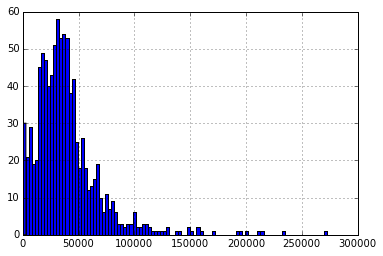

In [123]:
(pd.Series(survey_scenario.simulation.calculate_add('revdisp_mensuel_annuel'))[((u_c_ir - u_ir_a)<0)]).hist(bins = 100)

In [124]:
pay_irpp = (simulation.calculate('irpp') > 0)
print pay_irpp.shape
pd.value_counts(cast_array_from_entity_to_role(pay_irpp, 'foyer_fiscal', roles = [0]))

(59874,)


0    109945
1      2414
dtype: int64

In [125]:
decote_mensuel = simulation.calculate_add("decote_gain_fiscal_mensuel_times_12")/12
decote = simulation.calculate_add("decote_gain_fiscal")


has_decote_difference = (np.abs(decote -decote_mensuel)>0.1).astype(int)
has_decote_difference = cast_array_from_entity_to_role(has_decote_difference, 'foyer_fiscal', roles = [0])

nb_decote_diff_menage = sum_array_by_entity(has_decote_difference, 'menage')

print pd.value_counts(nb_decote_diff_menage)


utility_loss = (u_c_ir - u_ir_a)<-0.00000001
pd.value_counts(nb_decote_diff_menage[utility_loss])

#utility_loss = condition((u_c_ir - u_ir_a)<-0.00000001)
#utility_loss = cast_array_from_entity_to_role(utility_loss, roles = [0])


0    41315
1     7328
2      355
3       18
dtype: int64


/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:14: FutureWarning: in the future, boolean array-likes will be handled as a boolean array index


1    48505
0      511
dtype: int64

In [126]:
revdisp_loss = (simulation.calculate_add('revdisp_mensuel_compensated_ir_mensuel') - simulation.calculate_add('revdisp_mensuel_annuel')) < -1
#no_decote_or_payment_threshold_concern =  
good_rev_trav = switch_entity('rfr', 'menage')/switch_entity('nbptr', 'menage') > 20000
pd.value_counts(pd.Series(revdisp_loss)[good_rev_trav])

False    9602
True      225
dtype: int64

In [127]:
dico = {} #bizare, qu'est-ce qu'il se passe exactement ?
a = 7
for month in range(1,13):
    dico[month] = zip(pd.Series(simulation.calculate("revdisp_mensuel_compensated_ir_mensuel", period = "2009-{}".format(month)))[good_rev_trav&revdisp_loss][a:a+1], 
                      pd.Series(simulation.calculate_add('revdisp_mensuel_compensated_ir_mensuel') - simulation.calculate_add('revdisp_mensuel_annuel'))[good_rev_trav&revdisp_loss][a:a+1],
                      pd.Series(switch_entity('irpp', 'famille'))[good_rev_trav&revdisp_loss][a:a+1],
                      
                     
                     )

/usr/local/lib/python2.7/site-packages/pandas/core/internals.py:179: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 55306 but corresponding boolean dimension is 49016
  return self.values[slicer]
/usr/local/lib/python2.7/site-packages/pandas/core/index.py:1087: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 55306 but corresponding boolean dimension is 49016
  result = getitem(key)


In [128]:
dico

{1: [(3596.9731, -711.02344, -838.78497314453125)],
 2: [(3596.9731, -711.02344, -838.78497314453125)],
 3: [(3596.9731, -711.02344, -838.78497314453125)],
 4: [(3596.9731, -711.02344, -838.78497314453125)],
 5: [(3596.9731, -711.02344, -838.78497314453125)],
 6: [(3596.9731, -711.02344, -838.78497314453125)],
 7: [(3596.9731, -711.02344, -838.78497314453125)],
 8: [(3596.9731, -711.02344, -838.78497314453125)],
 9: [(3596.9731, -711.02344, -838.78497314453125)],
 10: [(412.77856, -711.02344, -838.78497314453125)],
 11: [(12.704166, -711.02344, -838.78497314453125)],
 12: [(12.704166, -711.02344, -838.78497314453125)]}

In [129]:
good_rev_trav.shape

(49016,)

In [130]:
pd.Series(nb_decote_diff_menage.astype('bool'))[utility_loss == True].value_counts(normalize = True) #Parmis les ménages ayant eu une perte d'utilité 56% ont eu une différence de décote.

True     0.598826
False    0.401174
dtype: float64

In [131]:
pd.Series(nb_decote_diff_menage.astype('bool'))[utility_loss == True].value_counts(normalize = True) #Parmis les ménages ayant eu une perte d'utilité 56% ont eu une différence de décote.

True     0.598826
False    0.401174
dtype: float64

In [132]:
(nb_decote_diff_menage.astype('bool')*weight_menages.values).sum()/weight_menages.sum()

0.15574227292934023

In [133]:
nb_decote_diff_menage

array([ 1.,  0.,  0., ...,  0.,  1.,  0.])

In [134]:
pd.Series(utility_loss)[nb_decote_diff_menage.astype('bool')].value_counts(normalize = True) #Parmis les ménages ayant eu une différence de décote 5% ont eu une perte d'utilité

False    0.960265
True     0.039735
dtype: float64

In [135]:
pd.Series(nb_decote_diff_menage.astype('bool'))[utility_loss == True].value_counts()

True     306
False    205
dtype: int64

In [136]:
u_c_ir.shape

(49016,)

In [137]:
pd.value_counts(sum_array_by_entity(has_decote_difference, 'menage'))

0    41315
1     7328
2      355
3       18
dtype: int64

In [138]:
ax = ((pd.Series(np.abs(decote -decote_mensuel)>0.1)[((u_c_ir - u_ir_a)<-0.00000001)]).value_counts( normalize = True)*100).plot(kind = "bar",)
plt.ylim((0,100))

labels = ["{}%".format(np.round(i,2)) for i in ((pd.Series(np.abs(decote -decote_mensuel)>0.1)[((u_c_ir - u_ir_a)<-0.0000001)]).value_counts( normalize = True)*100) ] #0.000001 pour éviter les erreurs d'arrondis.
rects = ax.patches

for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')

IndexingError: Unalignable boolean Series key provided

In [139]:
survey_scenario.simulation.persons.count

112359

In [140]:
is_decote_different = pd.Series(np.abs(decote -decote_mensuel)>0.1)[((u_c_ir - u_ir_a)<-0.00000001)]

IndexingError: Unalignable boolean Series key provided

In [141]:
#TODO for famille and check if it coorrespond to the 46.43%
below_collection_thrshld = np.zeros(weight_foyers.shape[0], dtype=bool)
for month in range(1,13):
    irpp_mensuel = pd.Series(survey_scenario.simulation.calculate("irpp_mensuel", '2009-{}'.format(month)))
    below_collection_thrshld += (irpp_mensuel>1) & (irpp_mensuel<5.16)
    

In [142]:
pd.Series(below_collection_thrshld).value_counts()

False    59386
True       488
dtype: int64

In [143]:
np.array([True, False])+np.array([True, True])

array([ True,  True], dtype=bool)

In [144]:
#Qui sont les gagnants ? :


In [145]:
is_decote_different[is_decote_different==False]

NameError: name 'is_decote_different' is not defined

In [146]:
pd.Series(np.abs(decote -decote_mensuel)>0.1)[((u_c_ir - u_ir_a)<0.000001)].value_counts(normalize = True)

IndexingError: Unalignable boolean Series key provided

In [147]:
(pd.Series(decote!= decote_mensuel)[((u_c_ir - u_ir_a)<0)]).hist(bins = 100)

IndexingError: Unalignable boolean Series key provided

In [148]:
revdisp[(u_c_ir>=u_ir_a)]

0         35028.031250
1          5938.395020
2         32096.173828
3         48278.339844
4         82396.765625
5         42299.699219
6         11817.129883
7          8589.000000
9         41731.035156
10        35603.992188
11        32725.292969
12        56515.160156
13        55318.828125
14        47963.703125
15        25208.322266
16        25065.869141
17        27230.187500
18        25096.802734
19        22376.177734
20        15390.793945
21        15582.432617
22           21.714211
23        13252.128906
24        34851.238281
25        36353.597656
26        14823.540039
27        36352.386719
28        62381.750000
29        23457.705078
30        75089.320312
31        56955.410156
32        54214.238281
33        62706.847656
34        20240.712891
35        80080.750000
36        43084.625000
37        26690.228516
38        28436.367188
39         7474.352539
40           -0.000000
41        19476.298828
42        15152.797852
43        18451.267578
44        2

In [149]:
print u_c_ir[(decote_annual==0) & (decote_monthly==0)].mean()
print u_ir_m[(decote_annual==0) & (decote_monthly==0)].mean()
print u_ir_a[(decote_annual==0) & (decote_monthly==0)].mean()

-0.000124609
-0.000124577
-0.00012502


## Qui sont les gagnants ?

In [150]:
print pd.value_counts((survey_scenario.simulation.calculate_add("revdisp_mensuel_annuel")-survey_scenario.simulation.calculate_add("revdisp_mensuel_ir_mensuel"))>1)
print pd.value_counts((survey_scenario.simulation.calculate_add("revdisp_mensuel_annuel")-survey_scenario.simulation.calculate_add("revdisp_mensuel_ir_mensuel"))<-1)

False    40491
True      8525
dtype: int64
False    47832
True      1184
dtype: int64


In [151]:
print pd.Series(((survey_scenario.simulation.calculate_add("revdisp_mensuel_annuel")-survey_scenario.simulation.calculate_add("revdisp_mensuel_ir_mensuel"))>1)
                     *weight_menages).sum()
print pd.Series(((survey_scenario.simulation.calculate_add("revdisp_mensuel_annuel")-survey_scenario.simulation.calculate_add("revdisp_mensuel_ir_mensuel"))<-1)
                      *weight_menages).sum()

4762330.0
631642.0


In [152]:
np.mean(
    (survey_scenario.simulation.calculate("rbg")/survey_scenario.simulation.calculate("nbptr"))\
    [survey_scenario.simulation.calculate_add("irpp")-survey_scenario.simulation.calculate_add("irpp_mensuel")>1]
    )

12579.479

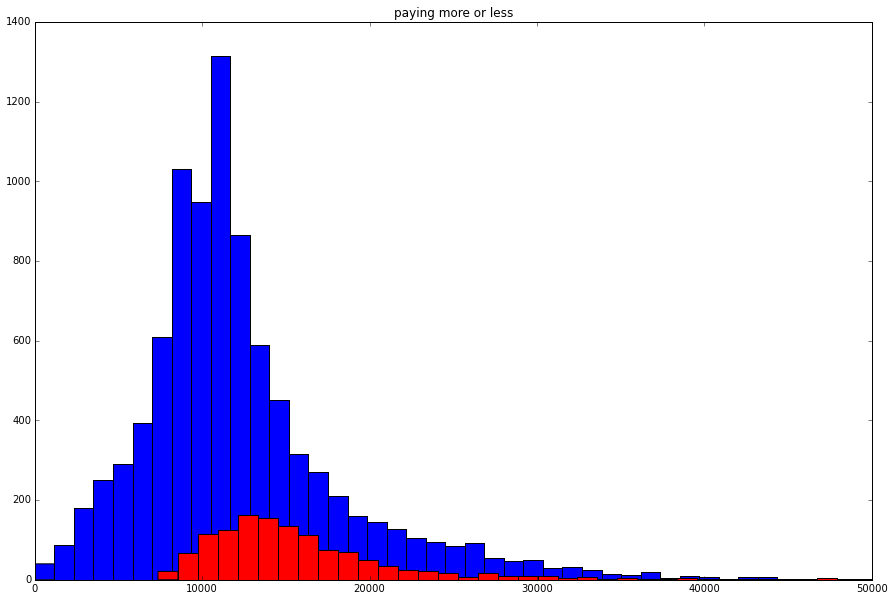

In [153]:
plt.figure(figsize=(15,10))
plt.hist(    (survey_scenario.simulation.calculate("rbg")/survey_scenario.simulation.calculate("nbptr"))\
    [survey_scenario.simulation.calculate_add("irpp")-survey_scenario.simulation.calculate_add("irpp_mensuel")>1], bins = 200, label = "Paying less on monthly basis")
plt.hist(    (survey_scenario.simulation.calculate("rbg")/survey_scenario.simulation.calculate("nbptr"))\
    [survey_scenario.simulation.calculate_add("irpp")-survey_scenario.simulation.calculate_add("irpp_mensuel")<-1], bins = 65, color= 'r', label = "Paying more on monthly basis")
plt.xlim(0,50000)
plt.title("paying more or less")

###### Weighted

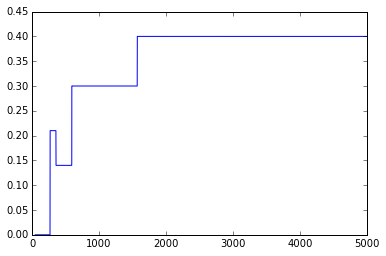

In [154]:
from openfisca_utils import make_ready_to_use_simulation
from openfisca_core import rates
simulation = make_ready_to_use_simulation.make_ready_to_use_simulation(2009,False)
rbg_test_case = simulation.calculate('rbg')
irpp_test_case = simulation.calculate('irpp')
marginal_rate = rates.marginal_rate(irpp_test_case, rbg_test_case)-1
to_change = pd.Series(marginal_rate)[marginal_rate>1].index
#to_change = pd.Series(rates.marginal_rate(irpp_test_case, rbg_test_case)-1)[rates.marginal_rate(irpp_test_case, rbg_test_case)-1>1].index
marginal_rate[to_change] = marginal_rate[to_change+1]
plt.plot(marginal_rate)

In [155]:
to_change = pd.Series(rates.marginal_rate(irpp_test_case, rbg_test_case)-1)[rates.marginal_rate(irpp_test_case, rbg_test_case)-1>1].index


In [156]:
pd.Series(marginal_rate)[marginal_rate>1]

Series([], dtype: float32)

In [157]:
np.mean(survey_scenario.simulation.calculate("rbg"))

23384.496

In [158]:
np.array([True,True,False]) *np.array([2,3,4])

array([2, 3, 0])

In [159]:
pd.value_counts((survey_scenario.simulation.calculate_add("revdisp_mensuel_annuel") - survey_scenario.simulation.calculate_add("revdisp_mensuel_compensated_ir_mensuel")>1))

False    48305
True       711
dtype: int64

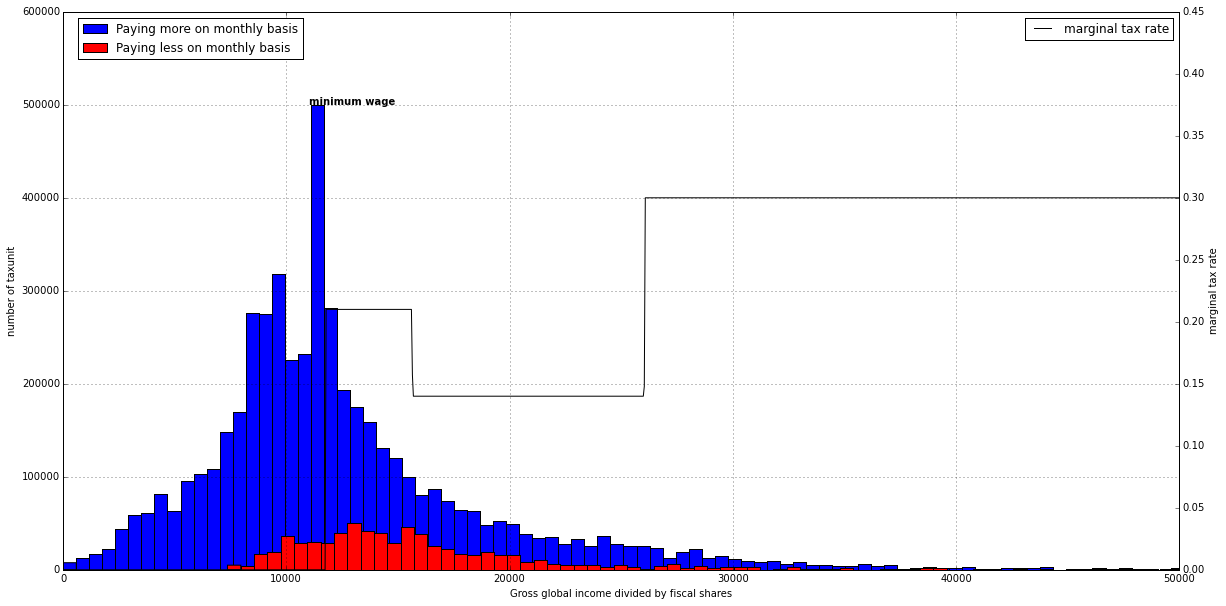

In [160]:


weights1 = weight_foyers[survey_scenario.simulation.calculate_add("irpp")-survey_scenario.simulation.calculate_add("irpp_mensuel")>1]
weights2 = weight_foyers[survey_scenario.simulation.calculate_add("irpp")-survey_scenario.simulation.calculate_add("irpp_mensuel")<-1]

fig, ax1 = plt.subplots(figsize=(20, 10))


ax1.hist(    (survey_scenario.simulation.calculate("rbg")/survey_scenario.simulation.calculate("nbptr"))\
    [(survey_scenario.simulation.calculate_add("irpp")-survey_scenario.simulation.calculate_add("irpp_mensuel"))>1], bins = 400, label = "Paying more on monthly basis", weights= weights1)
ax1.hist(    (survey_scenario.simulation.calculate("rbg")/survey_scenario.simulation.calculate("nbptr"))\
    [(survey_scenario.simulation.calculate_add("irpp")-survey_scenario.simulation.calculate_add("irpp_mensuel"))<-1], bins = 130, color= 'r', label = "Paying less on monthly basis",weights= weights2)


ax1.set_xlim(0,50000)
ax2 = plt.twinx()
ax2.plot(rbg_test_case[1:],marginal_rate, 'k', label = "marginal tax rate")
ax2.set_xlim(0,50000)
ax2.legend()
ax1.legend(bbox_to_anchor=(0.22, 1))
ax1.grid(which = 'both')
ax1.text(11000,500000, u"minimum wage", weight = 'bold',)
ax2.set_ylabel("marginal tax rate")
ax1.set_xlabel("Gross global income divided by fiscal shares")
ax1.set_ylabel("number of taxunit")
#plt.title("")


In [161]:
-(100 -  110)

10

In [162]:
survey_scenario.simulation.calculate_add("irpp_mensuel").mean()

-1639.9276

### Gains monetaires

#### Same annalysis with benefits

In [163]:
survey_scenario.compute_aggregate("rsa_socle_majore_mensualise")

330113186.26153564

In [164]:
survey_scenario.compute_aggregate("rsa_non_majore")

23828193080.302155

In [165]:
pd.Series(survey_scenario.simulation.calculate("rsa_eligibilite_tns", "2009-01")).value_counts()

True    55306
dtype: int64

# Utilitarian monetary gains

In [166]:
monetary_gain_ir = np.zeros(weight_menages.shape[0])
for month in range(1,10):
    monetary_gain_ir += (
    survey_scenario.simulation.calculate("inverted_utility_compensated_ir_mensuel", "2009-{}".format(month)) - 
    survey_scenario.simulation.calculate("inverted_utility_ir_annuel", "2009-{}".format(month))
    )*weight_menages

In [167]:
((monetary_gain_ir.sum(0)/10)*12)/10**9

0.98388087902896737

Gains moyens par ménages.

(-10000, 10000)

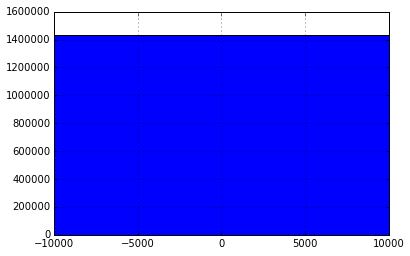

In [168]:
monetary_gain_ir = pd.Series(monetary_gain_ir)
monetary_gains_ir_0 = monetary_gain_ir[monetary_gain_ir != 0]
monetary_gains_ir_0.hist(bins = 500, weights = (pd.Series(weight_menages)[monetary_gain_ir != 0]).values)
plt.xlim(-10000,10000)

In [169]:
print pd.Series(monetary_gain_ir<-10).value_counts()
print pd.Series(monetary_gain_ir>10).value_counts()
pd.Series(monetary_gain_ir)[monetary_gain_ir>10].shape

False    46902
True      2114
dtype: int64
False    45868
True      3148
dtype: int64


(3148,)

In [170]:
month = 7
gain = pd.Series(survey_scenario.simulation.calculate("inverted_utility_compensated_ir_mensuel", "2009-{}".format(month)) - 
    survey_scenario.simulation.calculate("inverted_utility_ir_annuel", "2009-{}".format(month))
    )
gain[np.abs(gain)>1].mean()


26.583185

In [171]:
 diff_in_income = pd.Series(
    np.abs(survey_scenario.simulation.calculate("revdisp_mensuel_annuel", "2009-{}".format(month))
          - survey_scenario.simulation.calculate("revdisp_mensuel_compensated_ir_mensuel", "2009-{}".format(month)))>1
    )

In [172]:
weight_menages.sum(0)

27299608.0

In [173]:
#monetary_gain.sum(0)/10**9

#### Non compensated

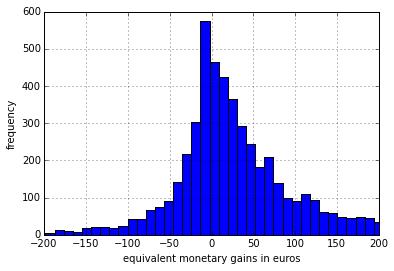

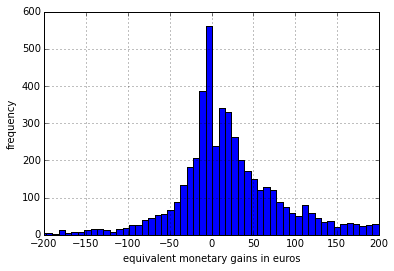

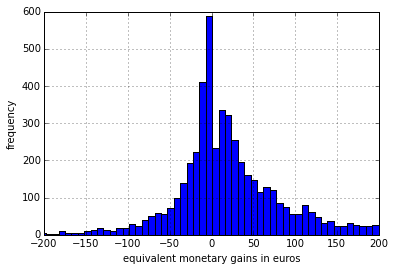

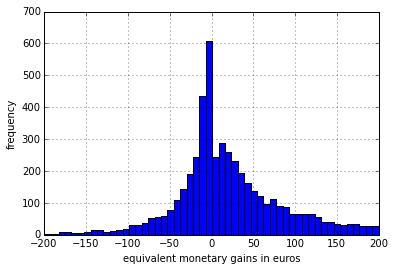

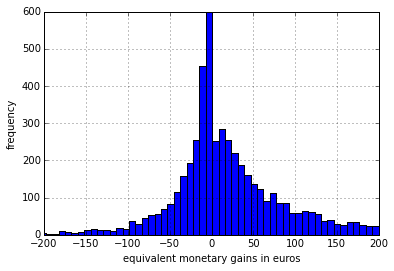

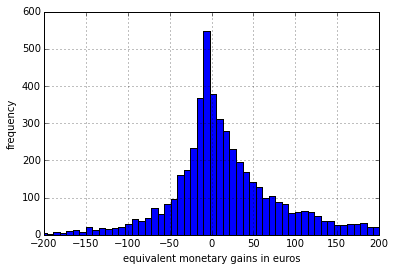

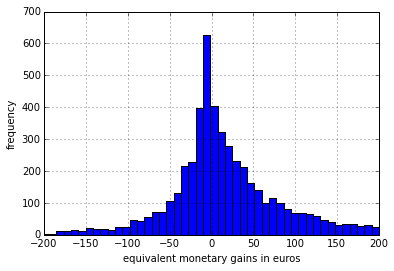

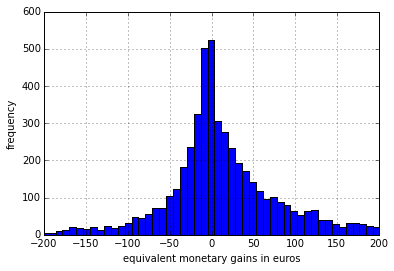

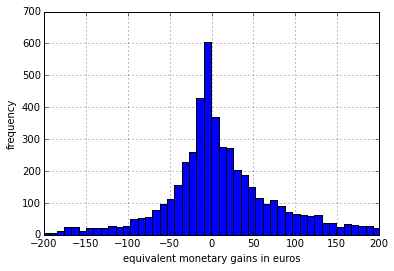

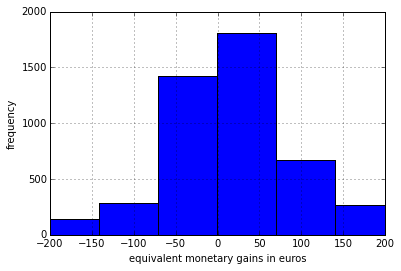

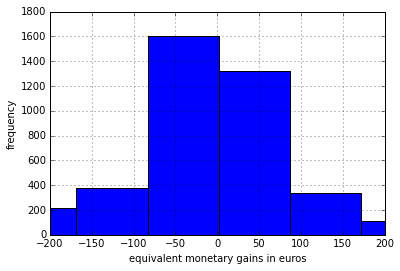

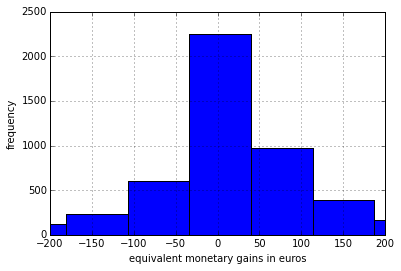

In [174]:
for month in range(1,13):
    gain_u = (pd.Series(
     survey_scenario.simulation.calculate("utility_ir_mensuel", "2009-{}".format(month)) - 
survey_scenario.simulation.calculate("utility_ir_annuel", "2009-{}".format(month))
        ))
    gain_m =  (
        survey_scenario.simulation.calculate("inverted_utility_compensated_ir_mensuel", "2009-{}".format(month)) - 
        survey_scenario.simulation.calculate("inverted_utility_ir_annuel", "2009-{}".format(month)))
    pd.DataFrame({'gain_utilite':gain_u, 'gain_argent':gain_m})
    plt.figure()
    pd.Series(gain_m)[gain_m!=0].hist(bins = 1500)
    plt.xlim(-200,200)
    plt.xlabel("equivalent monetary gains in euros ")
    plt.ylabel('frequency')
#TODO: problème sur les 3 derniers mois !

In [175]:
u_monetary_gain_ir = np.zeros(weight_menages.shape[0])
for month in range(1,10):
    u_monetary_gain_ir += (
    survey_scenario.simulation.calculate("inverted_utility_ir_mensuel", "2009-{}".format(month)) - 
    survey_scenario.simulation.calculate("inverted_utility_ir_annuel", "2009-{}".format(month))
    )*weight_menages

In [176]:
((u_monetary_gain_ir.sum(0)/10)*12)/10**9

-0.15892660922391355

In [177]:
u_monetary_gain_ir = np.zeros(weight_menages.shape[0])
for month in range(1,10):
    u_monetary_gain_ir += np.mean(
    (survey_scenario.simulation.calculate("inverted_utility_ir_mensuel", "2009-{}".format(month)) - 
    survey_scenario.simulation.calculate("inverted_utility_ir_annuel", "2009-{}".format(month)))*weight_menages
    )

In [178]:
((u_monetary_gain_ir.sum(0)/10)*12)/10**9

-0.15892660922391361

In [179]:
u_monetary_gain_ir = np.zeros(weight_menages.shape[0])
for month in range(1,12):
    u_monetary_gain_ir += (
    survey_scenario.simulation.calculate("inverted_utility_ir_mensuel", "2009-{}".format(month)) - 
    survey_scenario.simulation.calculate("inverted_utility_ir_annuel", "2009-{}".format(month))
    )*weight_menages

In [180]:
(u_monetary_gain_ir.sum(0))/10**9

-5.6656818727429812

In [181]:
month = 6
gain = pd.Series(survey_scenario.simulation.calculate("inverted_utility_ir_mensuel", "2009-{}".format(month)) - 
    survey_scenario.simulation.calculate("inverted_utility_ir_annuel", "2009-{}".format(month))
    )
mean_gain = gain[np.abs(gain)>1].mean()
print('{} gain on average'.format(mean_gain))

2.61817598343 gain on average


In [182]:
u_monetary_gain = np.zeros(weight_menages.shape[0])
for month in range(1,10):
    u_monetary_gain +=np.mean(
        pd.Series(survey_scenario.simulation.calculate("inverted_utility_compensated_ir_mensuel", "2009-{}".format(month)) - 
        survey_scenario.simulation.calculate("inverted_utility_ir_annuel", "2009-{}".format(month)))
               )
(((u_monetary_gain_ir/10)*12)/10**9).mean()  

-0.00013870610101378278

#### mean monetary equivalent utility gain for each month

In [183]:
u_money_gain = np.zeros(weight_menages.shape[0])
mean_gain = np.zeros(1)
for month in range(1,13):
    u_money_gain = pd.Series(survey_scenario.simulation.calculate("inverted_utility_ir_mensuel", "2009-{}".format(month)) - 
        survey_scenario.simulation.calculate("inverted_utility_ir_annuel", "2009-{}".format(month))
        )
    mean_gain += (u_money_gain[np.abs(u_money_gain)>1]).mean()
print('{} gain on average'.format(mean_gain[0]))

-1142.71731204 gain on average


In [184]:
#mean_gain = (u_gain[np.abs(u_gain)>1]).mean()

#### mean monetary equivalent utility gain over the year

In [186]:
u_annuelle = pd.Series(np.zeros(weight_menages.shape[0]))
u_mensuelle = pd.Series(np.zeros(weight_menages.shape[0]))
mean_gain = np.zeros(1)
for month in range(1,13):
    u_annuelle += pd.Series(
        survey_scenario.simulation.calculate("utility_ir_annuel", "2009-{}".format(month))
        )
    u_mensuelle += pd.Series(survey_scenario.simulation.calculate("utility_ir_mensuel", "2009-{}".format(month)) 
        )
eq_money_u_annuelle = np.exp((np.log(-u_annuelle))/-.87)
eq_money_u_mensuelle = np.exp((np.log(-u_mensuelle))/-.87)
impact_filter = (u_annuelle != u_mensuelle)

print('{} gain on average'.format(eq_money_u_mensuelle.mean() - eq_money_u_annuelle.mean()))
print('{} gain on average for concerned taxunits'.format(eq_money_u_mensuelle[impact_filter].mean() - eq_money_u_annuelle[impact_filter].mean()))

98.6942422567 gain on average
402.730351187 gain on average for concerned taxunits


In [ ]:
eq

In [ ]:
u_gain.describe()

#### Compensated

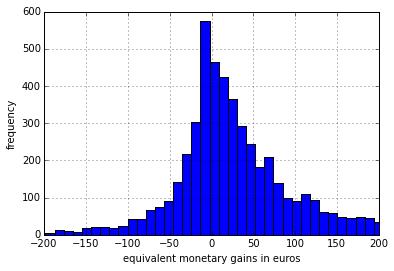

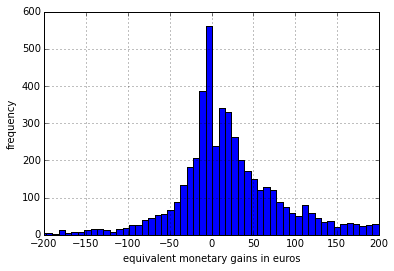

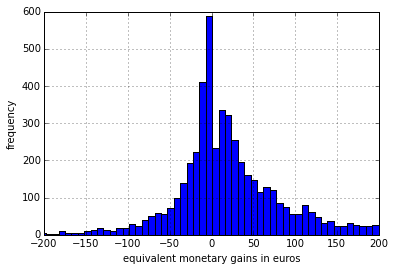

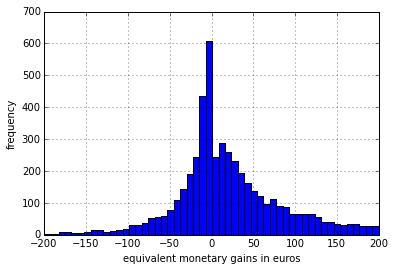

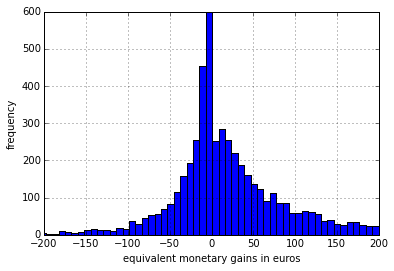

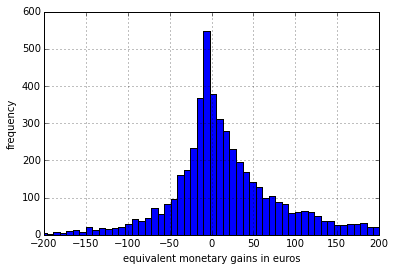

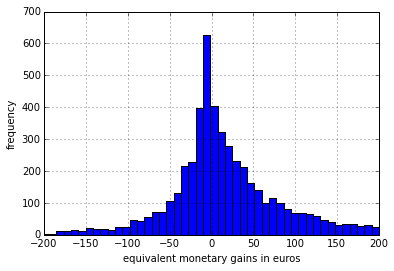

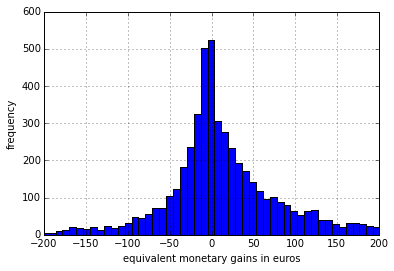

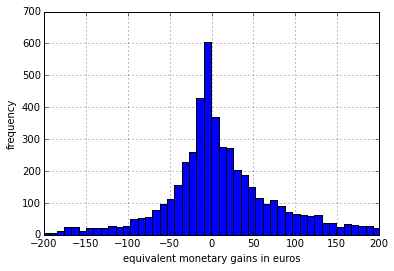

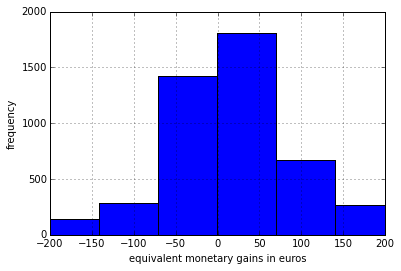

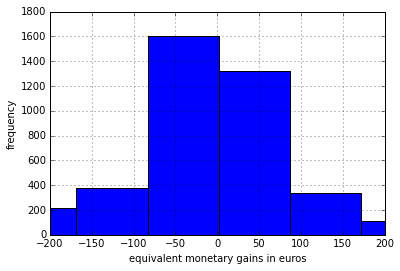

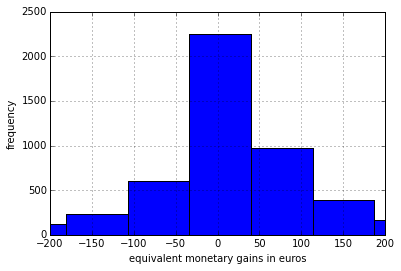

In [187]:
for month in range(1,13):
    gain_u = (pd.Series(
     survey_scenario.simulation.calculate("utility_compensated_ir_mensuel", "2009-{}".format(month)) - 
survey_scenario.simulation.calculate("utility_ir_annuel", "2009-{}".format(month))
        ))
    gain_m =  (
        survey_scenario.simulation.calculate("inverted_utility_compensated_ir_mensuel", "2009-{}".format(month)) - 
        survey_scenario.simulation.calculate("inverted_utility_ir_annuel", "2009-{}".format(month)))
    pd.DataFrame({'gain_utilite':gain_u, 'gain_argent':gain_m})
    plt.figure()
    pd.Series(gain_m)[gain_m!=0].hist(bins = 1500)
    plt.xlim(-200,200)
    plt.xlabel("equivalent monetary gains in euros ")
    plt.ylabel('frequency')
#TODO: problème sur les 3 derniers mois !

In [188]:
u_monetary_gain_ir = np.zeros(weight_menages.shape[0])
for month in range(1,10):
    u_monetary_gain_ir += (
    survey_scenario.simulation.calculate("utility_compensated_ir_mensuel", "2009-{}".format(month)) - 
    survey_scenario.simulation.calculate("inverted_utility_ir_annuel", "2009-{}".format(month))
    )*weight_menages

In [189]:
((u_monetary_gain_ir.sum(0)/10)*12)/10**9

-868.5655681778635

In [190]:
u_monetary_gain_ir = np.zeros(weight_menages.shape[0])
for month in range(1,10):
    u_monetary_gain_ir += np.mean(
    (survey_scenario.simulation.calculate("utility_compensated_ir_mensuel", "2009-{}".format(month)) - 
    survey_scenario.simulation.calculate("inverted_utility_ir_annuel", "2009-{}".format(month)))*weight_menages
    )

In [191]:
((u_monetary_gain_ir.sum(0)/10)*12)/10**9

-868.56556817786316

In [ ]:
month = 7
gain = pd.Series(survey_scenario.simulation.calculate("inverted_utility_compensated_ir_mensuel", "2009-{}".format(month)) - 
    survey_scenario.simulation.calculate("inverted_utility_ir_annuel", "2009-{}".format(month))
    )
mean_gain = gain[np.abs(gain)>1].mean()
print('{} gain on average'.format(mean_gain))

In [192]:
u_monetary_gain = np.zeros(weight_menages.shape[0])
for month in range(1,10):
    u_monetary_gain +=np.mean(
        pd.Series(survey_scenario.simulation.calculate("inverted_utility_compensated_ir_mensuel", "2009-{}".format(month)) - 
        survey_scenario.simulation.calculate("inverted_utility_ir_annuel", "2009-{}".format(month)))
               )
(((u_monetary_gain_ir/10)*12)/10**9).mean()  

-0.017720041785903858

#### mean monetary equivalent utility gain over the year

In [193]:
u_annuelle = pd.Series(np.zeros(weight_menages.shape[0]))
u_mensuelle = pd.Series(np.zeros(weight_menages.shape[0]))
mean_gain = np.zeros(1)
for month in range(1,13):
    u_annuelle += pd.Series(
        survey_scenario.simulation.calculate("utility_ir_annuel", "2009-{}".format(month))
        )
    u_mensuelle += pd.Series(survey_scenario.simulation.calculate("utility_compensated_ir_mensuel", "2009-{}".format(month)) 
        )
eq_money_u_annuelle = np.exp((np.log(-u_annuelle))/-.87)
eq_money_u_mensuelle = np.exp((np.log(-u_mensuelle))/-.87)
impact_filter = (u_annuelle != u_mensuelle)

print('{} gain on average'.format(eq_money_u_mensuelle.mean() - eq_money_u_annuelle.mean()))
print('{} gain on average for concerned taxunits'.format(eq_money_u_mensuelle[impact_filter].mean() - eq_money_u_annuelle[impact_filter].mean()))


107.200007945 gain on average
836.04066658 gain on average for concerned taxunits


In [194]:
u_annuelle = pd.Series(np.zeros(weight_menages.shape[0]))
u_mensuelle = pd.Series(np.zeros(weight_menages.shape[0]))
mean_gain = np.zeros(1)
for month in range(1,13):
    u_annuelle += pd.Series(a
                            `
        survey_scenario.simulation.calculate("utility_ir_annuel", "2009-{}".format(month))
        )
    u_mensuelle += pd.Series(survey_scenario.simulation.calculate("utility_ir_mensuel_rsa_mensuel", "2009-{}".format(month)) 
        )
eq_money_u_annuelle = np.exp((np.log(-u_annuelle))/-.87)
eq_money_u_mensuelle = np.exp((np.log(-u_mensuelle))/-.87)
impact_filter = (u_annuelle != u_mensuelle)

print('{} gain on average'.format(eq_money_u_mensuelle.mean() - eq_money_u_annuelle.mean()))
print('{} gain on average for concerned taxunits'.format(eq_money_u_mensuelle[impact_filter].mean() - eq_money_u_annuelle[impact_filter].mean()))


SyntaxError: invalid syntax (<ipython-input-194-98da8b737f38>, line 6)

In [195]:
u_mensuelle

0       -0.000079
1       -0.000236
2       -0.000084
3       -0.000079
4       -0.000040
5       -0.000104
6       -0.000165
7       -0.000197
8       -0.000130
9       -0.000069
10      -0.000131
11      -0.000085
12      -0.000054
13      -0.000055
14      -0.000061
15      -0.000100
16      -0.000255
17      -0.000095
18      -0.000100
19      -0.000109
20      -0.000140
21      -0.000139
22      -0.000433
23      -0.000154
24      -0.000079
25      -0.000076
26      -0.000143
27      -0.000082
28      -0.000050
29      -0.000105
30      -0.000043
31      -0.000060
32      -0.000056
33      -0.000050
34      -0.000117
35      -0.000041
36      -0.000067
37      -0.000096
38      -0.000092
39      -0.000212
40      -0.000434
41      -0.000120
42      -0.000141
43      -0.000124
44      -0.000107
45      -0.000115
46      -0.000105
47      -0.000079
48      -0.000124
49      -0.000100
50      -0.000066
51      -0.000130
52      -0.000067
53      -0.000070
54      -0.000052
55      -0

### RSA+IR

In [196]:
for month in range(1,13):
    gain_u = (pd.Series(
     survey_scenario.simulation.calculate("utility_ir_mensuel_rsa_mensuel", "2009-{}".format(month)) - 
survey_scenario.simulation.calculate("utility_ir_annuel", "2009-{}".format(month))
        ))
    gain_m =  (
        survey_scenario.simulation.calculate("inverted_utility_compensated_ir_mensuel_rsa_mensuel", "2009-{}".format(month)) - 
        survey_scenario.simulation.calculate("inverted_utility_ir_annuel", "2009-{}".format(month)))
    pd.DataFrame({'gain_utilite':gain_u, 'gain_argent':gain_m})
    plt.figure()
    pd.Series(gain_m)[gain_m!=0].hist(bins = 1500)
    plt.xlim(-200,200)
    plt.xlabel("equivalent monetary gains in euros ")
    plt.ylabel('frequency')
#TODO: problème sur les 3 derniers mois !

KeyError: 'inverted_utility_compensated_ir_mensuel_rsa_mensuel'

In [ ]:
monetary_gain_ir_rsa = np.zeros(weight_menages.shape[0])
for month in range(1,10):
    monetary_gain_ir_rsa += (
    survey_scenario.simulation.calculate("inverted_utility_compensated_ir_mensuel_rsa_mensuel", "2009-{}".format(month)) - 
    survey_scenario.simulation.calculate("inverted_utility_ir_annuel", "2009-{}".format(month))
    )*weight_menages

In [ ]:
((monetary_gain_ir_rsa.sum(0)/10)*12)/10**9

## Gains et perte passage à la retraite.

In [ ]:
print survey_scenario.simulation.persons.simulation.entity_by_key_plural

In [ ]:
coucou.entity.simulation

In [ ]:
c = np.zeros(1)
a = np.array([1,2,3])
b = np.array([True,True,False])
c += a[b]; c

In [ ]:
is_retired = np.zeros(weight_individus.shape[0])
is_active = np.zeros(weight_individus.shape[0])
is_inactive = np.zeros(weight_individus.shape[0])
for month in range(1,13):
    is_retired += survey_scenario.simulation.calculate("retraite_imposable", "2009-{}".format(month))>0
    is_active += survey_scenario.simulation.calculate("salaire_imposable", "2009-{}".format(month))>0
    is_inactive += (survey_scenario.simulation.calculate("salaire_imposable", "2009-{}".format(month)) + survey_scenario.simulation.calculate("retraite_imposable", "2009-{}".format(month))) == 0

In [ ]:
(pd.Series(is_retired + is_active + is_inactive).hist(bins= 12))

In [ ]:
is_retired = np.zeros(weight_individus.shape[0])
is_active = np.zeros(weight_individus.shape[0])
is_inactive = np.zeros(weight_individus.shape[0])
is_retire_active = np.zeros(weight_individus.shape[0])

for month in range(1,13):
    retraite_imposable = survey_scenario.simulation.compute("retraite_imposable", "2009-{}".format(month))
    salaire_imposable = survey_scenario.simulation.compute("salaire_imposable", "2009-{}".format(month))
    is_retired += retraite_imposable.array >0
    is_active += salaire_imposable.array > 0 
    is_retire_active += (retraite_imposable.array >0) & (salaire_imposable.array > 0 )
    is_inactive += (retraite_imposable.array == 0) & (salaire_imposable.array == 0 )
    

In [ ]:
is_retire_is_active_not_retire_active = ((is_retire_active == 0)
                                         & (is_active>0)
                                         & (is_inactive >0)
                                         )

In [ ]:
survey_scenario.simulation.tax_benefit_system.Variable.formula_class.sum_by_entity(retraite_imposable)

In [ ]:
survey_scenario.simulation.tax_benefit_system.Variable.formula_class.sum_by_entity('h')

In [ ]:
 type(class_name.encode('utf-8'), (Reform.DatedVariable,), definitions_by_name)

In [ ]:
pd.Series(is_retire_is_active_not_retire_active).value_counts()

In [ ]:
(pd.Series(is_retired + is_active + is_inactive)).value_counts()

In [ ]:
passage_a_la_retraite = pd.Series(is_retired) & pd.Series(is_not_retired)

## Revdisp over the year

## Annual IR Basis

In [143]:
revdisp_oy = pd.DataFrame()
temp = pd.DataFrame()
for month in range(1,13):
    for var in ['salaire_imposable', 'chomage_imposable', 'pen_mensuel', 'psoc_mensuel', 'ppe']:
        temp[var] = pd.Series(np.sum(survey_scenario.simulation.calculate(var, "2009-{}".format(month))))
    temp['impo'] = pd.Series(np.sum(survey_scenario.simulation.calculate('impo', "2009".format(month))))/12
    temp['rev_cap'] = pd.Series(np.sum(survey_scenario.simulation.calculate('rev_cap', "2009".format(month))))/12
    revdisp_oy = revdisp_oy.append(temp, ignore_index=True)
revdisp_oy.index = range(1,13)
revdisp_oy

,salaire_imposable,chomage_imposable,pen_mensuel,psoc_mensuel,ppe,impo,rev_cap
1,80446056,3401369.75,27179322,8116128.5,388890.5625,-7378242.666667,146923.083333
2,80205280,3339581.25,27200762,4782682.5,388890.5625,-7378242.666667,146923.083333
3,80154912,3433212.50,27403234,5027160.0,388890.5625,-7378242.666667,146923.083333
4,80183488,3356610.50,27280964,8150251.0,388890.5625,-7378242.666667,146923.083333
5,80182728,3462323.00,27561876,5730149.0,388890.5625,-7378242.666667,146923.083333
6,80186344,3621052.50,27925554,5686628.0,388890.5625,-7378242.666667,146923.083333
7,80155752,3779776.50,28094176,5689500.5,388890.5625,-7378242.666667,146923.083333
8,80345952,3978757.75,28543968,5609103.0,388890.5625,-7378242.666667,146923.083333
9,80677472,4363786.00,29311400,5559448.5,388890.5625,-7378242.666667,146923.083333
10,81388208,4971175.00,28707408,5916309.0,388890.5625,-7378242.666667,146923.083333


#### With weight

In [144]:
revdisp_oy = pd.DataFrame()
temp = pd.DataFrame()
for month in range(1,13):
    for var in ['salaire_imposable', 'chomage_imposable', 'pen_mensuel',]:
        temp[var] = pd.Series(np.sum(survey_scenario.simulation.calculate(var, "2009-{}".format(month))* weight_individus))
    for var in ['psoc_mensuel']:
        temp[var] = pd.Series(np.sum(survey_scenario.simulation.calculate(var, "2009-{}".format(month))* weight_familles))      
    temp['impo'] = pd.Series(np.sum(survey_scenario.simulation.calculate('impo', "2009".format(month))* weight_menages))/12
    temp['rev_cap'] = pd.Series(np.sum(survey_scenario.simulation.calculate('rev_cap', "2009".format(month))))/12
    revdisp_oy = revdisp_oy.append(temp, ignore_index=True)
    

revdisp_oy.index = range(1,13)
revdisp_oy/10**9

,salaire_imposable,chomage_imposable,pen_mensuel,psoc_mensuel,impo,rev_cap
1,46.035288,1.988781,12.544919,4.394287,-4.00459,0.000147
2,45.911349,1.966999,12.577170,2.571006,-4.00459,0.000147
3,45.915476,2.084441,12.740929,2.702532,-4.00459,0.000147
4,45.947659,1.934130,12.562599,4.484328,-4.00459,0.000147
5,45.926885,1.995026,12.733947,3.108409,-4.00459,0.000147
6,45.875387,2.120168,12.955677,3.086955,-4.00459,0.000147
7,45.898869,2.211393,13.022996,3.098778,-4.00459,0.000147
8,45.964801,2.337075,13.255434,3.051979,-4.00459,0.000147
9,46.157049,2.538842,13.616544,3.026573,-4.00459,0.000147
10,46.501451,2.785263,13.339886,3.198544,-4.00459,0.000147


In [145]:
print (revdisp_oy/10**9).to_latex()

\begin{tabular}{lrrrrrr}
\toprule
{} &  salaire\_imposable &  chomage\_imposable &  pen\_mensuel &  psoc\_mensuel &     impo &   rev\_cap \\
\midrule
1  &          46.035288 &           1.988781 &    12.544919 &      4.394287 & -4.00459 &  0.000147 \\
2  &          45.911349 &           1.966999 &    12.577170 &      2.571006 & -4.00459 &  0.000147 \\
3  &          45.915476 &           2.084441 &    12.740929 &      2.702532 & -4.00459 &  0.000147 \\
4  &          45.947659 &           1.934130 &    12.562599 &      4.484328 & -4.00459 &  0.000147 \\
5  &          45.926885 &           1.995026 &    12.733947 &      3.108409 & -4.00459 &  0.000147 \\
6  &          45.875387 &           2.120168 &    12.955677 &      3.086955 & -4.00459 &  0.000147 \\
7  &          45.898869 &           2.211393 &    13.022996 &      3.098778 & -4.00459 &  0.000147 \\
8  &          45.964801 &           2.337075 &    13.255434 &      3.051979 & -4.00459 &  0.000147 \\
9  &          46.157049 &         

In [ ]:
ax = revdisp_oy.plot(kind = 'bar', stacked = 'True',alpha = 0.6, figsize=(15,9) )
#ax = fig.add_subplot(111)

plt.hlines(0,-1,13, linestyles='dashed', linewidth = 3, alpha = 0.9)

plt.xlabel("months", fontsize = 15)
plt.ylabel("euros", fontsize = 15)
plt.legend( bbox_to_anchor=(1, 0, 1, 1), loc=3,)
plt.savefig("image_result_of_mensualisation/revdisp_ir_annual.png")

## Monthly Basis

In [ ]:
revdisp_oy = pd.DataFrame()
temp = pd.DataFrame()
for month in range(1,13):
    for var in ['salaire_imposable', 'chomage_imposable', 'pen_mensuel', 'psoc_mensuel', 'ppe']:
        temp[var] = pd.Series(np.sum(survey_scenario.simulation.calculate(var, "2009-{}".format(month))))
    temp['impo_mensuel'] = pd.Series(np.sum(survey_scenario.simulation.calculate('impo_mensuel', "2009-{}".format(month))))
    temp['rev_cap'] = pd.Series(np.sum(survey_scenario.simulation.calculate('rev_cap', "2009".format(month))))/12
    revdisp_oy = revdisp_oy.append(temp, ignore_index=True)
revdisp_oy.index = range(1,13)
revdisp_oy

### With weight

In [ ]:
revdisp_oy = pd.DataFrame()
temp = pd.DataFrame()
for month in range(1,13):
    for var in ['salaire_imposable', 'chomage_imposable', 'pen_mensuel']:
        temp[var] = pd.Series(np.sum(survey_scenario.simulation.calculate(var, "2009-{}".format(month))* weight_individus))
    for var in ['psoc_mensuel']:
        temp[var] = pd.Series(np.sum(survey_scenario.simulation.calculate(var, "2009-{}".format(month))* weight_familles))      
    temp['impo_mensuel'] = pd.Series(np.sum(survey_scenario.simulation.calculate('impo_mensuel', "2009-{}".format(month))* weight_menages))
    temp['rev_cap'] = pd.Series(np.sum(survey_scenario.simulation.calculate('rev_cap', "2009".format(month))*weight_individus))/12
    revdisp_oy = revdisp_oy.append(temp, ignore_index=True)

revdisp_oy.index = range(1,13)
revdisp_oy/10**9

In [ ]:
ax = revdisp_oy.plot(kind = 'bar', stacked = 'True',alpha = 0.6, figsize=(15,9) )
#ax = fig.add_subplot(111)

plt.hlines(0,-1,13, linestyles='dashed', linewidth = 3, alpha = 0.9)

plt.xlabel("months", fontsize = 15)
plt.ylabel("euros", fontsize = 15)
plt.legend( bbox_to_anchor=(1, 0, 1, 1), loc=3,)
plt.savefig("image_result_of_mensualisation/revdisp_ir_monthly.png")

In [ ]:
revdisp_oy['total'] = revdisp_oy.sum(1)
print (revdisp_oy/10**9).to_latex()

## Compensated Monthly Basis

In [ ]:
revdisp_oy = pd.DataFrame()
temp = pd.DataFrame()
for month in range(1,13):
    for var in ['salaire_imposable', 'chomage_imposable', 'pen_mensuel', 'psoc_mensuel', 'ppe']:
        temp[var] = pd.Series(np.sum(survey_scenario.simulation.calculate(var, "2009-{}".format(month))))
    temp['impo_mensuel'] = pd.Series(np.sum(survey_scenario.simulation.calculate('compensated_impo_mensuel', "2009-{}".format(month))))
    temp['rev_cap'] = pd.Series(np.sum(survey_scenario.simulation.calculate('rev_cap', "2009".format(month))))/12
    revdisp_oy = revdisp_oy.append(temp, ignore_index=True)
revdisp_oy.index = range(1,13)
revdisp_oy

### With weight

In [ ]:
revdisp_oy = pd.DataFrame()
temp = pd.DataFrame()
for month in range(1,13):
    for var in ['salaire_imposable', 'chomage_imposable', 'pen_mensuel']:
        temp[var] = pd.Series(np.sum(survey_scenario.simulation.calculate(var, "2009-{}".format(month))* weight_individus))
    for var in ['psoc_mensuel']:
        temp[var] = pd.Series(np.sum(survey_scenario.simulation.calculate(var, "2009-{}".format(month))* weight_familles))      
    temp['impo_mensuel'] = pd.Series(np.sum(survey_scenario.simulation.calculate('compensated_impo_mensuel', "2009-{}".format(month))* weight_menages))
    temp['rev_cap'] = pd.Series(np.sum(survey_scenario.simulation.calculate('rev_cap', "2009".format(month))*weight_individus))/12
    revdisp_oy = revdisp_oy.append(temp, ignore_index=True)
revdisp_oy.index = range(1,13)
revdisp_oy/10**9

In [ ]:
ax = revdisp_oy.plot(kind = 'bar', stacked = 'True',alpha = 0.6, figsize=(15,9) )
#ax = fig.add_subplot(111)

plt.hlines(0,-1,13, linestyles='dashed', linewidth = 3, alpha = 0.9)

plt.xlabel("months", fontsize = 15)
plt.ylabel("euros", fontsize = 15)
plt.legend( bbox_to_anchor=(1, 0, 1, 1), loc=3,)
plt.savefig("image_result_of_mensualisation/revdisp_ir_comp_monthly.png")

In [ ]:
revdisp_oy['total'] = revdisp_oy.sum(1)
print (revdisp_oy/10**9).to_latex()

## Compensated Rsa monthly

In [ ]:
revdisp_oy = pd.DataFrame()
temp = pd.DataFrame()
for month in range(1,13):
    for var in ['salaire_imposable', 'chomage_imposable', 'pen_mensuel', 'psoc_mensuel_rsa_mensuel', 'ppe']:
        temp[var] = pd.Series(np.sum(survey_scenario.simulation.calculate(var, "2009-{}".format(month))))
    temp['impo_mensuel'] = pd.Series(np.sum(survey_scenario.simulation.calculate('compensated_impo_mensuel', "2009-{}".format(month))))
    temp['rev_cap'] = pd.Series(np.sum(survey_scenario.simulation.calculate('rev_cap', "2009".format(month))))/12
    revdisp_oy = revdisp_oy.append(temp, ignore_index=True)
revdisp_oy.index = range(1,13)
revdisp_oy

### With weight

In [ ]:
revdisp_oy = pd.DataFrame()
temp = pd.DataFrame()
for month in range(1,13):
    for var in ['salaire_imposable', 'chomage_imposable', 'pen_mensuel']:
        temp[var] = pd.Series(np.sum(survey_scenario.simulation.calculate(var, "2009-{}".format(month))* weight_individus))
    for var in ['psoc_mensuel_rsa_mensuel']:
        temp[var] = pd.Series(np.sum(survey_scenario.simulation.calculate(var, "2009-{}".format(month))* weight_familles))      
    temp['impo_mensuel'] = pd.Series(np.sum(survey_scenario.simulation.calculate('compensated_impo_mensuel', "2009-{}".format(month))* weight_menages))
    temp['rev_cap'] = pd.Series(np.sum(survey_scenario.simulation.calculate('rev_cap', "2009".format(month))*weight_individus))/12
    revdisp_oy = revdisp_oy.append(temp, ignore_index=True)
revdisp_oy.index = range(1,13)
revdisp_oy/10**9

In [ ]:
ax = revdisp_oy.plot(kind = 'bar', stacked = 'True',alpha = 0.6, figsize=(15,9) )
#ax = fig.add_subplot(111)

plt.hlines(0,-1,13, linestyles='dashed', linewidth = 3, alpha = 0.9)

plt.xlabel("months", fontsize = 15)
plt.ylabel("euros", fontsize = 15)
plt.legend( bbox_to_anchor=(1, 0, 1, 1), loc=3,)
plt.savefig("image_result_of_mensualisation/revdisp_rsa_ir_comp_monthly.png")

In [ ]:
revdisp_oy['total'] = revdisp_oy.sum(1)
print (revdisp_oy/10**9).to_latex()

In [ ]:
revdisp_oy = pd.DataFrame()
temp = pd.DataFrame()
for month in range(1,13):
    for var in ['rev_trav_mensuel', 'pen_mensuel', 'chomage_imposable', 'pen_mensuel', 'ppe']:
        temp[var] = pd.Series(np.sum(survey_scenario.simulation.calculate(var, "2009-{}".format(month))))
    temp['psoc_mensuel'] = - pd.Series(np.sum(survey_scenario.simulation.calculate('psoc_mensuel', "2009-{}".format(month))))
    temp['impo'] = pd.Series(np.sum(survey_scenario.simulation.calculate('impo', "2009".format(month))))/12
    revdisp_oy = revdisp_oy.append(temp, ignore_index=True)
revdisp_oy.index = range(1,13)
revdisp_oy

In [ ]:

undecompsed_revdisp = pd.DataFrame()
temp = pd.DataFrame()
for month in range(1,13):
    temp['revdisp_mensuel_annuel'] = pd.Series(np.sum(survey_scenario.simulation.calculate('revdisp_mensuel_annuel', "2009-{}".format(month))))
    undecompsed_revdisp = undecompsed_revdisp.append(temp, ignore_index=True)
    

In [ ]:
undecompsed_revdisp.index = range(1,13)

In [ ]:
df1 = pd.DataFrame({'revdisp_mensuel_annuel':revdisp_oy.sum(1).values}) 
df1.index = range(1,13)
(df1 - undecompsed_revdisp)/10**9

In [ ]:
undecompsed_revdisp.index = np.arange(-0.5,11.5,1)

In [ ]:
undecompsed_revdisp.index = np.arange(-0.5,11.5, 1) #TODO: pouruoi une différence ?
ax = revdisp_oy.plot(kind = 'bar', stacked = 'True',alpha = 0.2, figsize=(15,9) )
#ax = fig.add_subplot(111)
plt.bar(undecompsed_revdisp.index, undecompsed_revdisp.values, color = 'k', alpha = 0.4)
plt.hlines(0,-1,13, linestyles='dashed', linewidth = 3, alpha = 0.5)

plt.xlabel("months", fontsize = 15)
plt.ylabel("headcount", fontsize = 15)
plt.legend( bbox_to_anchor=(1, 0, 1, 1), loc=3,)

In [ ]:
undecompsed_revdisp.index = np.arange(-0.5,11.5, 1) #TODO: pouruoi une différence ?
ax = revdisp_oy.plot(kind = 'bar', stacked = 'True',alpha = 0.6, figsize=(15,9) )
#ax = fig.add_subplot(111)

plt.hlines(0,-1,13, linestyles='dashed', linewidth = 3, alpha = 0.9)

plt.xlabel("months", fontsize = 15)
plt.ylabel("headcount", fontsize = 15)
plt.legend( bbox_to_anchor=(1, 0, 1, 1), loc=3,)

In [ ]:
undecompsed_revdisp


## Monthly IR basis 

In [ ]:
revdisp_oy = pd.DataFrame()
temp = pd.DataFrame()
for month in range(1,13):
    for var in ['salaire_imposable', 'chomage_imposable', 'pen_mensuel', 'psoc_mensuel', 'ppe', 'impo_mensuel']:
        temp[var] = pd.Series(np.sum(survey_scenario.simulation.calculate(var, "2009-{}".format(month))))
        temp['psoc_mensuel'] = - pd.Series(np.sum(survey_scenario.simulation.calculate('psoc_mensuel', "2009-{}".format(month))))
    revdisp_oy = revdisp_oy.append(temp, ignore_index=True)
revdisp_oy.index = range(1,13)
revdisp_oy
revdisp_oy.plot(kind = 'bar', stacked = 'True', figsize=(15,9) )
plt.hlines(0,-1,13, linestyles='dashed', linewidth = 3, alpha = 0.5)
plt.xlabel("months", fontsize = 15)
plt.ylabel("headcount", fontsize = 15)
plt.legend( loc=2)

In [ ]:
plt.close()
plt.figure()

#### With weight

In [ ]:
revdisp_oy = pd.DataFrame()
temp = pd.DataFrame()
for month in range(1,13):
    for var in ['salaire_imposable', 'chomage_imposable', 'pen_mensuel']:
        temp[var] = pd.Series(np.sum(survey_scenario.simulation.calculate(var, "2009-{}".format(month))* weight_individus))
    for var in ['psoc_mensuel']:
        temp[var] = pd.Series(np.sum(survey_scenario.simulation.calculate(var, "2009-{}".format(month))* weight_familles))      
    temp['impo_mensuel'] = pd.Series(np.sum(survey_scenario.simulation.calculate('impo_mensuel', "2009".format(month))* weight_menages))/12
    temp['rev_cap'] = pd.Series(np.sum(survey_scenario.simulation.calculate('rev_cap', "2009".format(month))*weight_individus))/12
    revdisp_oy = revdisp_oy.append(temp, ignore_index=True)
revdisp_oy.index = range(1,13)
revdisp_oy.index = range(1,13)

revdisp_oy.plot(kind = 'bar', stacked = 'True', figsize=(15,9) )
plt.hlines(0,-1,13, linestyles='dashed', linewidth = 3, alpha = 0.5)
plt.xlabel("months", fontsize = 15)
plt.ylabel("headcount", fontsize = 15)
plt.legend( loc=2)

In [ ]:
revdisp_oy = pd.DataFrame()
temp = pd.DataFrame()
for month in range(1,13):
    for var in ['salaire_imposable', 'chomage_imposable', 'pen_mensuel']:
        temp[var] = pd.Series(np.sum(survey_scenario.simulation.calculate(var, "2009-{}".format(month))* weight_individus))
    for var in ['psoc_mensuel']:
        temp[var] = pd.Series(np.sum(survey_scenario.simulation.calculate(var, "2009-{}".format(month))* weight_familles))      
    temp['impo_mensuel'] = pd.Series(np.sum(survey_scenario.simulation.calculate('impo', "2009".format(month))* weight_menages))/12
    temp['rev_cap'] = pd.Series(np.sum(survey_scenario.simulation.calculate('rev_cap', "2009".format(month))))/12
    revdisp_oy = revdisp_oy.append(temp, ignore_index=True)
revdisp_oy.index = range(1,13)
revdisp_oy/10**9

In [ ]:
revdisp_oy.index = range(1,13)
revdisp_oy.index = range(1,13)

revdisp_oy.plot(kind = 'bar', stacked = 'True', figsize=(15,9) )
plt.hlines(0,-1,13, linestyles='dashed', linewidth = 3, alpha = 0.5)
plt.xlabel("months", fontsize = 15)
plt.ylabel("headcount", fontsize = 15)
plt.legend( loc=2)

In [ ]:
revdisp_oy/10**9

In [ ]:
print (revdisp_oy/10**9).to_latex()

## Monthly IR compensated

In [ ]:
revdisp_oy = pd.DataFrame()
temp = pd.DataFrame()
for month in range(1,13):
    for var in ['salaire_imposable', 'chomage_imposable', 'pen_mensuel', 'psoc_mensuel', 'ppe', 'compensated_impo_mensuel']:
        temp[var] = pd.Series(np.sum(survey_scenario.simulation.calculate(var, "2009-{}".format(month))))
    revdisp_oy = revdisp_oy.append(temp, ignore_index=True)
revdisp_oy.index = range(1,13)
revdisp_oy
revdisp_oy.plot(kind = 'bar', stacked = 'True', figsize=(15,9) )
plt.xlabel("months", fontsize = 15)
plt.ylabel("headcount", fontsize = 15)
plt.legend( loc=2)

In [ ]:
revdisp_oy = pd.DataFrame()
for month in range(1,13):
    revdisp_oy['{}'.format(month)] = pd.Series(survey_scenario.simulation.calculate("rev_trav_mensuel", "2009-{}".format(month)))

In [ ]:
'a'

In [ ]:
revdisp_oy.sum(0).plot(kind = 'bar', color = 'b')

#### By income type

In [ ]:
revdisp_oy = pd.DataFrame()
for month in range(1,13):
    revdisp_oy['{}'.format(month)] = pd.Series(survey_scenario.simulation.calculate("salaire_imposable", "2009-{}".format(month)))

revdisp_oy.sum(0).plot(kind = 'bar')
plt.ylim(8*10**7)


In [ ]:
revdisp_oy = pd.DataFrame()
for month in range(1,13):
    revdisp_oy['{}'.format(month)] = pd.Series(survey_scenario.simulation.calculate("pen_mensuel", "2009-{}".format(month)))

revdisp_oy.sum(0).plot(kind = 'bar')


In [ ]:
revdisp_oy = pd.DataFrame()
for month in range(1,13):
    revdisp_oy['{}'.format(month)] = pd.Series(survey_scenario.simulation.calculate("psoc_mensuel", "2009-{}".format(month)))

revdisp_oy.sum(0).plot(kind = 'bar')


In [ ]:
revdisp_oy = pd.DataFrame()
for month in range(1,13):
    revdisp_oy['{}'.format(month)] = pd.Series(survey_scenario.simulation.calculate("ppe", "2009-{}".format(month)))

revdisp_oy.sum(0).plot(kind = 'bar')


In [ ]:
revdisp_oy = pd.DataFrame()
for month in range(1,13):
    revdisp_oy['{}'.format(month)] = pd.Series(survey_scenario.simulation.calculate("impo_mensuel", "2009-{}".format(month)))

revdisp_oy.sum(0).plot(kind = 'bar')


In [ ]:
revdisp_oy = pd.DataFrame()
for month in range(1,13):
    revdisp_oy['{}'.format(month)] = pd.Series(survey_scenario.simulation.calculate("retraite_imposable", "2009-{}".format(month)))

revdisp_oy.sum(0).plot(kind = 'bar')


In [ ]:
survey_scenario.simulation.calculate("retraite_imposable", "2009-{}".format(month))

# END

### Taux d'intérêt

In [ ]:
def revdisp_tx(var = None, taux = None):
    revdisp_i = 0
    for month in range(0,12):
        monthly_taux = ((1+taux)**(1/12)) 
        revdisp_i += (
            survey_scenario.simulation.calculate(var, survey_scenario.simulation.period.offset(month, 'month').this_month) 
            / (monthly_taux)**month 
                      )
    return revdisp_i


In [ ]:
revdisp_tx('revdisp_mensuel_ir_mensuel', 1.6)

In [ ]:
survey_scenario.simulation.period.offset(2, 'month').this_month